***Import Libraries***

In [1]:
"""This program linearizes 3R planar dyanmics using koopman theory and autoencoder to map"""
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import scipy.io
import torch

# bilinear Koopman
from core.koopman_core_linear import KoopDNN, KoopmanNet, KoopmanNetCtrl
from models.koop_model import model_matricies,lift
from core.util import fit_standardizer
from sklearn import preprocessing

# forward map neural net
from core.neural_fwd_map import map_Net
from models.neural_jacob_map import neural_jacobian, neural_jacobian_dot
# controllability
from core.util import Output_Con
import control as ct

## bilinear ControlModel
from control_files.nmpc_osqp import NonlinearMPCController
from dynamics.learned_models_control.linear_dynamics import linear_Dynamics

## import paths
from paths.paths import path_pars, path_pars_2D

## extra libraries
import numpy as np
import scipy as sp
from scipy import sparse



In [2]:
## define paths
robot = '3R_mat'
nature = 'linear'
modality = '3D'

robot_type_load = robot +'/' + modality # for data load0
robot_type = robot +'/'+ nature +'/' + modality # for saving purposes

train = False
mass_var = False
standardize = True


if mass_var == True:
    file_data = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data_mass_var.mat'
else:
    file_data = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data.mat'
    

    
file_data_fwd = 'dynamics/Dataset_MATLAB/' + robot_type_load +'/data_fw.mat'



In [3]:
file_data

'dynamics/Dataset_MATLAB/3R_mat/3D/data.mat'

### Load Data

In [4]:
data = scipy.io.loadmat(file_data)
data_fw = scipy.io.loadmat(file_data_fwd)

X_end = np.array(data['X_end'], dtype = 'float64')
X_full = np.array(data['X'], dtype = 'float64')
U_full = np.array(data['tau'], dtype = 'float64')

X_end_fw = np.array(data_fw['X_end_fw'], dtype = 'float64')
X_fw = np.array(data_fw['X_fw'], dtype = 'float64')

print(X_end.shape, X_full.shape,U_full.shape)

(200, 1001, 3) (200, 1001, 6) (200, 1000, 3)


In [5]:
np.sum(np.sum(np.isnan(X_end))), np.sum(np.sum(np.isnan(U_full))), np.sum(np.sum(np.isnan(X_full)))

(0, 0, 0)

***Simulation Parameters***

In [6]:
dt = float(data['dt']) #time step
num_snaps = int(data['num_snaps']) # no. of snapshots
num_traj = int(data['num_traj']) #no of trajectories
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = int(0.75*num_traj) # no. of training examples
num_val = num_traj-num_train # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = X_full.shape[2] # no. of states
num_joints = int(num_states/2)
num_inputs = U_full.shape[2] # no. of inputs
num_states_cart = int(X_end.shape[2])

In [7]:
dt, num_snaps, num_traj, num_states, num_inputs

(0.005, 1000, 200, 6, 3)

***Plotting the trajectories***

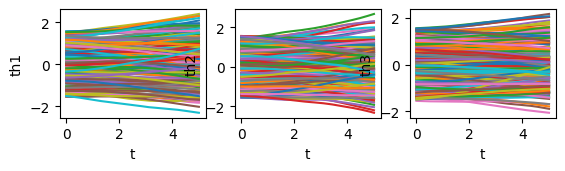

In [8]:
"""Training dataset visualization"""
#theta evolution
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1))
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i])

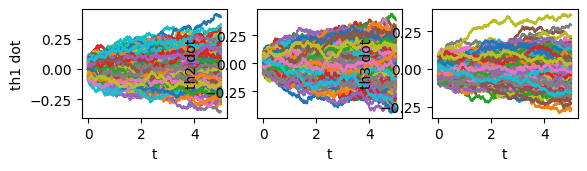

In [9]:
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.xlabel("t")
    plt.ylabel("th"+str(i+1)+ ' dot')
    for j in range(num_traj):
        plt.plot(T,X_full[j,:,i+int(num_joints)])

In [10]:
#x and y positions of the end effector
# %matplotlib widget
# ax = plt.axes(projection='3d')
# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_zlabel("z")
# for i in range(num_traj):
#     ax.plot3D(X_end[i,:,0],X_end[i,:,1],X_end[i,:,2])
    
# plt.axis('equal')

(-0.8557576927747478,
 1.0583966431626246,
 -1.0859538470940129,
 1.0821992187833305)

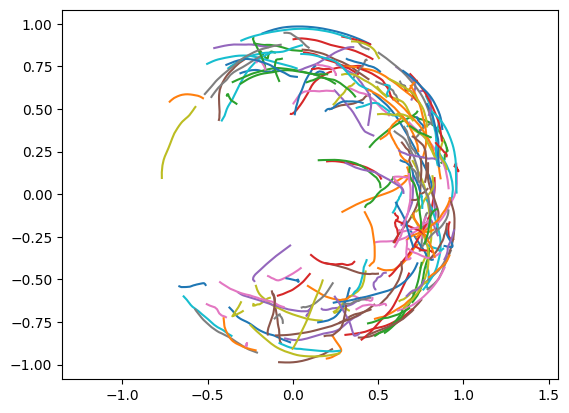

In [11]:
for i in range(num_traj):
    plt.plot(X_end[i,:,0],X_end[i,:,1])
    
plt.axis('equal')

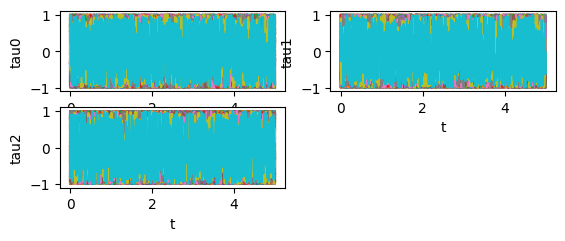

In [12]:
for i in range(num_inputs):
    plt.subplot(4,2,i+1)
    plt.xlabel("t")
    plt.ylabel("tau"+str(i))
    for j in range(num_traj):
        plt.plot(T[:-1],U_full[j,:,i])

***Training and validation datasets***

In [13]:
# split training and vaidation datasets
xs_train, us_train = X_full[:num_train,:,:],U_full[:num_train,:,:]
xs_val, us_val = X_full[num_train:,:,:],U_full[num_train:,:,:]

In [14]:
# import scipy.io
# Data_set = {"x_end": X_end, "X_full": X_full}
# scipy.io.savemat("Data_set.mat",Data_set)

In [15]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

***Model Training***

In [16]:
net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30 # 30
net_params['encoder_hidden_depth'] = 3  # 2
net_params['encoder_output_dim'] = 20   # 20
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 100
net_params['batch_size'] = 128
net_params['lifted_loss_penalty'] = 0.4 
net_params['l2_reg'] = 0.00       
net_params['l1_reg'] = 0.00
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifetd state
net_params['dt'] = dt

In [17]:
                                                    
if mass_var == True:
    file_koop = 'saved_models/'+robot_type+'/koop_arch_con_mass_var.pth'
else:
    file_koop = 'saved_models/'+robot_type+'/koop_arch_con.pth'
    
standardizer_u_kdnn = fit_standardizer(us_train, preprocessing.StandardScaler(with_mean = True))
# standardizer_x_kdnn = fit_standardizer(xs_train, preprocessing.StandardScaler(with_mean=False))

if train == True:
    
    if standardize:
        net = KoopmanNetCtrl(net_params, standardizer_u=standardizer_u_kdnn)
    else:
        net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file_koop)
else:
    model_koop_dnn = torch.load(file_koop)


***Learning Curves***

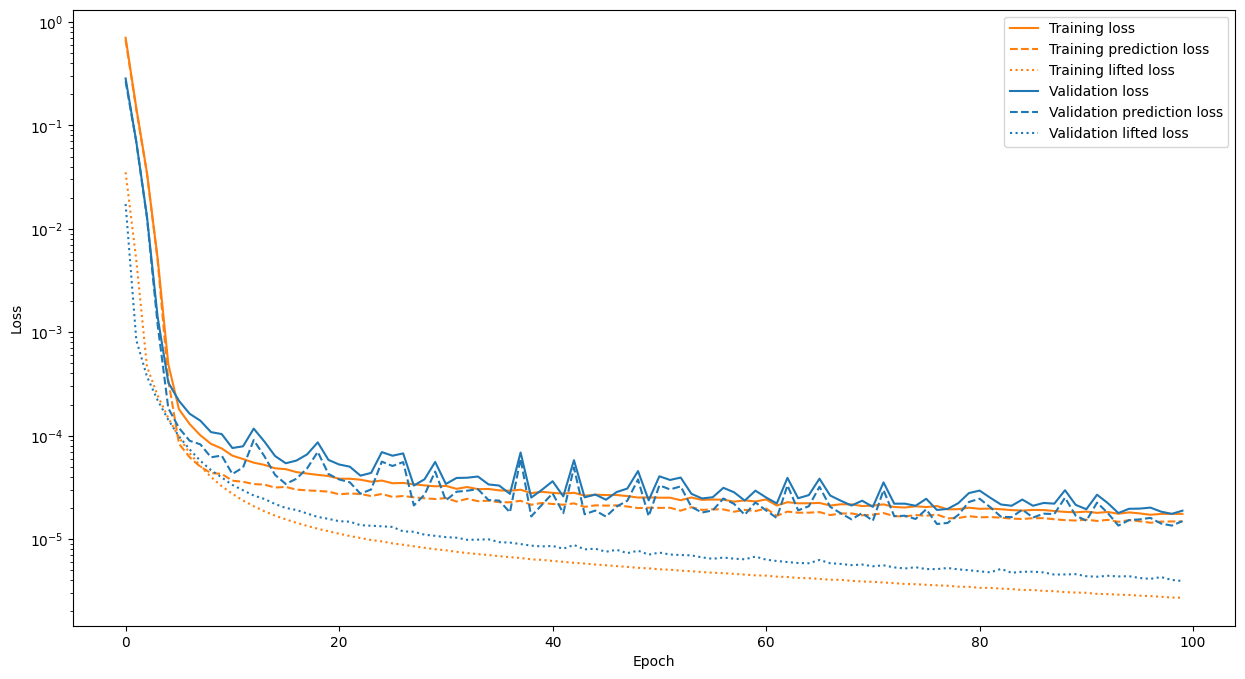

In [18]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot for arch1")
plt.show()


In [19]:
map_net_params = {}
map_net_params["input_dim"] = int(num_joints) #number of joint angles
map_net_params["output_dim"] = X_end.shape[2] #x and y position of the end effector
map_net_params["hidden_width"] = 20 #20
map_net_params["hidden_depth"] = 4  #2
map_net_params["batch_size"] = 128  #100
map_net_params["epochs"] = 200      # 500
map_net_params["activation_type"] = 'tanh'
map_net_params["lr"] = 1e-3     #1e-3
map_net_params["optimizer"] = 'adam'
map_net_params['l2_reg'] = 0.0
map_net_params['l1_reg'] = 0.0

In [20]:
#dataset
# split training and vaidation datasets
xs_map_train, ys_map_train = X_fw[:num_train,:,:int(num_joints)],X_end_fw[:num_train,:,:num_inputs]
xs_map_val, ys_map_val = X_fw[num_train:,:,:int(num_joints)],X_end_fw[num_train:,:,:num_inputs]

In [21]:
ys_map_train.shape, ys_map_val.shape,xs_map_train.shape, xs_map_val.shape

((150, 1000, 3), (50, 1000, 3), (150, 1000, 3), (50, 1000, 3))

In [22]:
#Initalize network
#Initalize network
train  = False
if mass_var == True:
    file_fwd = 'saved_models/'+ robot_type +'/map_net_con_mass_var.pth' 
else:
    file_fwd = 'saved_models/'+ robot_type +'/map_net_con.pth'

if train == True:
    map_net = map_Net(map_net_params)
    map_net.set_dataset_map(xs_map_train,ys_map_train,xs_map_val,ys_map_val)
    map_net.data_pipeline()
    torch.save(map_net,file_fwd)
else:
    map_net = torch.load(file_fwd)


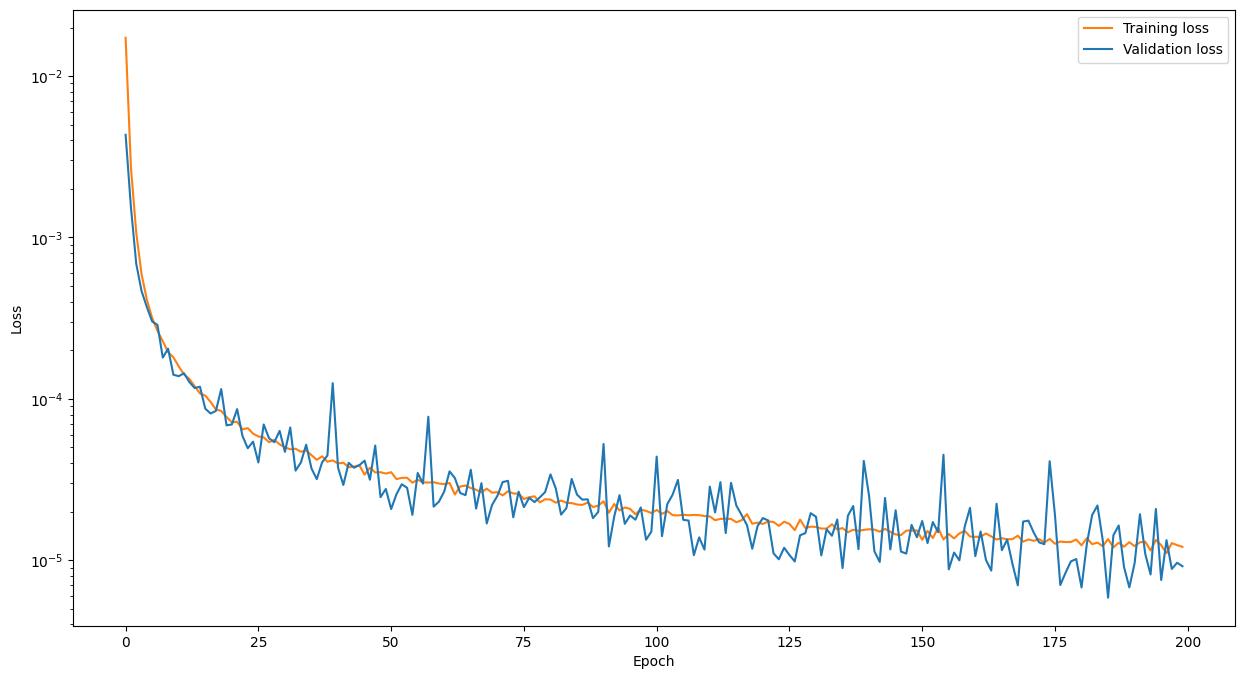

In [23]:
epochs = np.arange(0, map_net_params['epochs'])
plt.figure(figsize=(15,8))
plt.plot(epochs, map_net.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, map_net.val_loss_hist, color='tab:blue', label='Validation loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.savefig("convergence plot of map net for arch1[3,20,20,2]")
plt.show()

In [24]:
# import scipy.io
path_model = 'saved_models/'+ robot_type +'/matlab_files/' 

#save net parameters
scipy.io.savemat(path_model + "map_in_weights.mat", {"map_in_weights": map_net.map_net_in.weight.detach().numpy()})
scipy.io.savemat(path_model + "map_in_bias.mat", {"map_in_bias": map_net.map_net_in.bias.detach().numpy()})

scipy.io.savemat(path_model +"map_hidden_weights_1.mat",
                 {"map_hidden_weights_1": map_net.map_net_hid[0].weight.detach().numpy()})
scipy.io.savemat(path_model +"map_hidden_bias_1.mat",
                 {"map_hidden_bias_1": map_net.map_net_hid[0].bias.detach().numpy()})

scipy.io.savemat(path_model +"map_hidden_weights_2.mat",
                 {"map_hidden_weights_2": map_net.map_net_hid[1].weight.detach().numpy()})
scipy.io.savemat(path_model + "map_hidden_bias_2.mat",
                 {"map_hidden_bias_2": map_net.map_net_hid[1].bias.detach().numpy()})

scipy.io.savemat(path_model + "map_hidden_weights_3.mat",
                 {"map_hidden_weights_3": map_net.map_net_hid[2].weight.detach().numpy()})
scipy.io.savemat(path_model +"map_hidden_bias_3.mat",
                 {"map_hidden_bias_3": map_net.map_net_hid[2].bias.detach().numpy()})

scipy.io.savemat(path_model + "map_out_weights.mat", {"map_out_weights": map_net.map_net_out.weight.detach().numpy()})
scipy.io.savemat(path_model + "map_out_bias.mat", {"map_out_bias": map_net.map_net_out.bias.detach().numpy()})

In [25]:
map_net.map_net_hid

ModuleList(
  (0-2): 3 x Linear(in_features=20, out_features=20, bias=True)
)

## Test Data Parameters

In [26]:
# test data parameters
num_snaps_val = num_snaps # no. of snapshots
T = np.linspace(0,num_snaps_val*dt, num_snaps_val+1)
num_traj_val = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

***Koopman Bilinear Model***


In [27]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(27, 27) (27, 3) (6, 27)


## Controlability

In [28]:
Ac = (A-np.eye(n_obs))/dt
Bc = B/dt
Cc = C
Cr = C[0:3,:]

Cr_v = C[num_joints:2*num_joints,:]


In [29]:
A.shape, B.shape

((27, 27), (27, 3))

In [30]:
#check controllability
Con_lin = ct.ctrb(Ac, Bc)
rank_lin = np.linalg.matrix_rank(Con_lin)

print(rank_lin)

26


In [31]:
out_con_mat, out_con_rank = Output_Con(Ac,Bc,Cc)


print(out_con_mat.shape)
print(out_con_rank)

(6, 84)
6


In [32]:
# continiouts
print('mean full',np.linalg.pinv(Bc).mean())
print('rank full',np.linalg.matrix_rank(Bc))

print('mean full',np.linalg.pinv(Ac).mean())
print('rank full',np.linalg.matrix_rank(Ac))

mean full 0.054166436
rank full 3
mean full 14.977374525698087
rank full 26


In [33]:
# continiouts
print('mean full',np.linalg.pinv(np.matmul(C,Bc)).mean(),np.linalg.pinv(np.matmul(C,Ac)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,Bc)), np.linalg.matrix_rank(np.matmul(C,Ac)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr,Bc)).mean(),np.linalg.pinv(np.matmul(Cr,Ac)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr,Bc)),np.linalg.matrix_rank(np.matmul(Cr,Ac)))

mean full 0.9784688 0.1214207187439297
rank full 3 6
mean reduced -9986.609 0.11699646188454545
rank reduced 3 3


In [34]:
# discreate
print('mean full',np.linalg.pinv(np.matmul(C,B)).mean(),np.linalg.pinv(np.matmul(C,A)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,B)), np.linalg.matrix_rank(np.matmul(C,A)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr,B)).mean(),np.linalg.pinv(np.matmul(Cr,A)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr,B)),np.linalg.matrix_rank(np.matmul(Cr,A)))

mean full 195.69377 0.037051145
rank full 3 6
mean reduced -1997321.5 0.037082702
rank reduced 3 3


In [35]:
print('mean full',np.linalg.pinv(np.matmul(C,B)).mean(),np.linalg.pinv(np.matmul(C,A)).mean())
print('rank full',np.linalg.matrix_rank(np.matmul(C,B)), np.linalg.matrix_rank(np.matmul(C,A)))

print('mean reduced',np.linalg.pinv(np.matmul(Cr_v,B)).mean(),np.linalg.pinv(np.matmul(Cr_v,A)).mean())
print('rank reduced',np.linalg.matrix_rank(np.matmul(Cr_v,B)),np.linalg.matrix_rank(np.matmul(Cr_v,A)))

mean full 195.69377 0.037051145
rank full 3 6
mean reduced 391.36542 0.037077446
rank reduced 3 3


In [36]:
# #SAVE MATRIX PARAMETERS AS MATLAB FILE
# import scipy.io

dyn_matrices = {"A": A, "B": B, "C": C}
scipy.io.savemat(path_model + "dyn_mat.mat", dyn_matrices)
#save encoder parameters
scipy.io.savemat(path_model + "in_weights.mat", {"encode_in_weights": model_koop_dnn.net.encoder_fc_in.weight.detach().numpy()})
scipy.io.savemat(path_model + "in_bias.mat", {"encode_in_bias": model_koop_dnn.net.encoder_fc_in.bias.detach().numpy()})

scipy.io.savemat(path_model + "hidden_weights_1.mat",
                 {"encode_hidden_weights_1": model_koop_dnn.net.encoder_fc_hid[0].weight.detach().numpy()})
scipy.io.savemat(path_model + "hidden_bias_1.mat",
                 {"encode_hidden_bias_1": model_koop_dnn.net.encoder_fc_hid[0].bias.detach().numpy()})

scipy.io.savemat(path_model + "hidden_weights_2.mat",
                 {"encode_hidden_weights_2": model_koop_dnn.net.encoder_fc_hid[1].weight.detach().numpy()})
scipy.io.savemat(path_model + "hidden_bias_2.mat",
                 {"encode_hidden_bias_2": model_koop_dnn.net.encoder_fc_hid[1].bias.detach().numpy()})

scipy.io.savemat(path_model + "out_weights.mat", {"encode_out_weights": model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()})
scipy.io.savemat(path_model + "out_bias.mat", {"encode_out_bias": model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()})

if standardize:
    scipy.io.savemat(path_model + "std.mat", {"standardize": standardize, 'mean': standardizer_u_kdnn.mean_, 'scale':standardizer_u_kdnn.scale_})
    
else:
    scipy.io.savemat(path_model + "std.mat", {"standardize": standardize})

In [37]:
path_model

'saved_models/3R_mat/linear/3D/matlab_files/'

In [38]:
encode_out_bias = model_koop_dnn.net.encoder_fc_out.bias.detach().numpy()
encode_out_weights = model_koop_dnn.net.encoder_fc_out.weight.detach().numpy()

***Test Data Generation***

In [39]:
# data_gen
j = 10
xs_end_test = X_end[j,:,:]
xs_test = X_full[j,:,:]
us_test = U_full[j,:,:]

In [40]:
print(xs_end_test.shape, xs_test.shape, us_test.shape)

(1001, 3) (1001, 6) (1000, 3)


In [41]:
print(model_koop_dnn.test_loss(xs_test.reshape(1,-1,num_states),u_test = us_test.reshape(1,-1,num_inputs)))

tensor(9.9438e-06)


In [42]:
basis = model_koop_dnn.net.encode_forward_

In [43]:
X,_ = model_koop_dnn.net.process(xs_test.reshape(1,-1,num_states),data_u = us_test.reshape(1,-1,num_inputs))
print(X.shape)

(1000, 15)


In [44]:
x = X[:, :num_states]
u = X[:, num_states:num_states+num_inputs]
x_prime = X[:,num_states+num_inputs:]

print(x.shape, u.shape, x_prime.shape)

(1000, 6) (1000, 3) (1000, 6)


***Initial Condition Lifting***

In [45]:
# initialize the matricies
z = np.empty((n_obs,num_snaps_val+1)).T
x_est = np.zeros((num_states,num_snaps_val+1)).T
x_end_est = np.zeros((X_end.shape[2],num_snaps_val)).T

In [46]:
z[0,:] = lift(x[0,:],model_koop_dnn, net_params)
x_est[0,:] = x[0,:]

***Time Evolution***

In [47]:
for i in range(num_snaps_val):
  #bilinear
    z[i+1,:] = np.matmul(z[i,:],A.T)+np.matmul(u[i,:],B.T)
    x_est[i+1,:] = np.matmul(z[i+1,:],C.T)  
    x_end_est[i,:] = map_net.forward(torch.from_numpy(x_est[i,:int(num_joints)]).float()).detach().numpy()

***Visualization***

# Joint Space

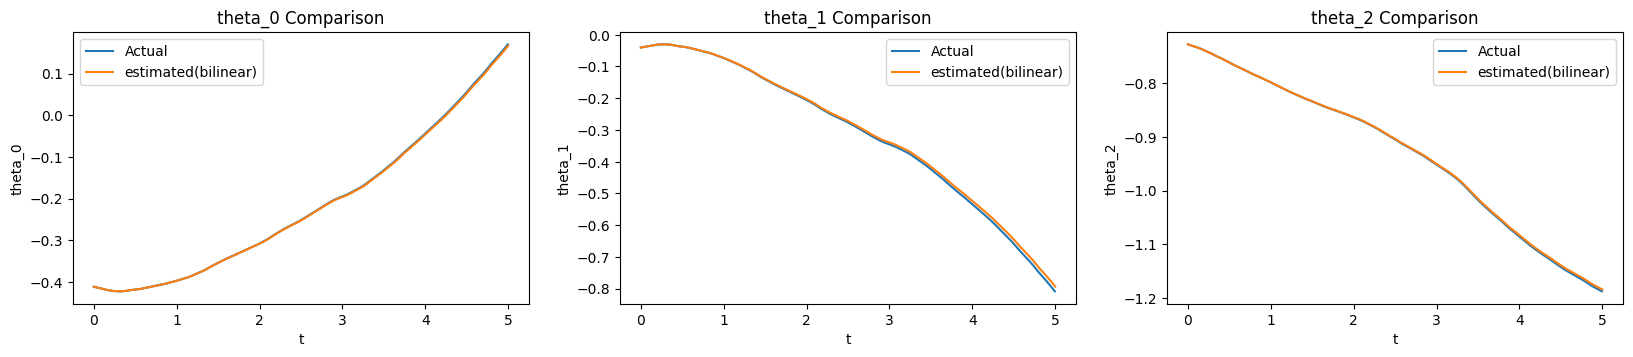

In [48]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],x[:,i],label ='Actual')
    plt.plot(T[:],x_est[:,i],label = 'estimated(bilinear)')
    plt.xlabel('t')
    plt.ylabel('theta_' + str(i))
    plt.title('theta_' + str(i) + ' Comparison')
    plt.legend()

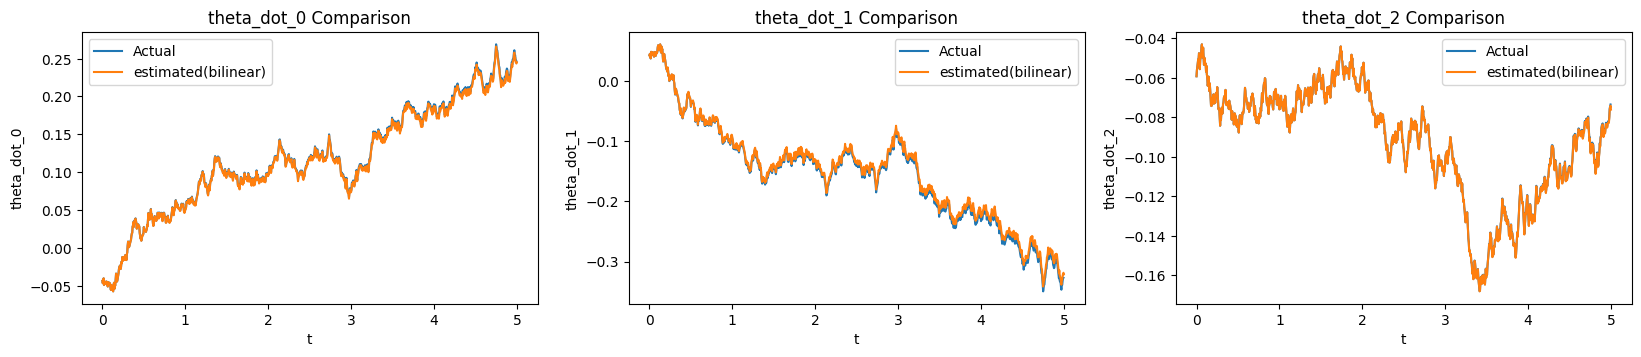

In [49]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],x[:,int(num_joints)+i],label ='Actual')
    plt.plot(T[:],x_est[:,int(num_joints)+i],label = 'estimated(bilinear)')
    plt.xlabel('t')
    plt.ylabel('theta_dot_' + str(i))
    plt.title('theta_dot_' + str(i) + ' Comparison')
    plt.legend()

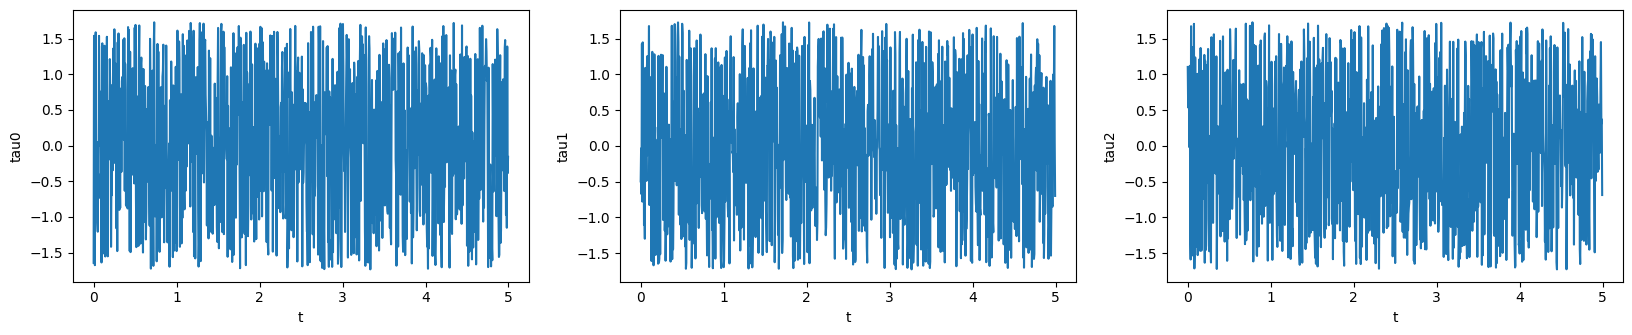

In [50]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],u[:,i])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

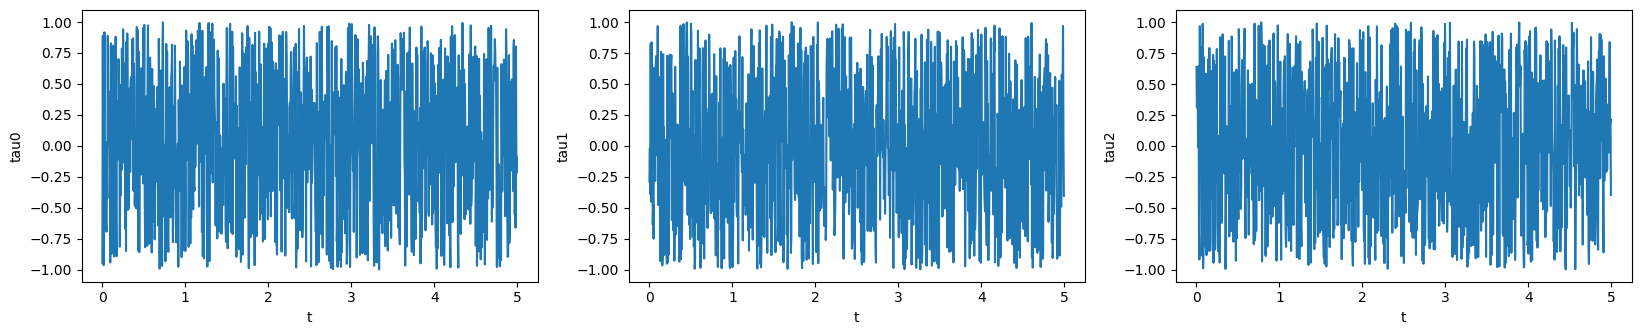

In [51]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(T[:-1],us_test[:,i])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

(1000, 3)
(1000, 3)


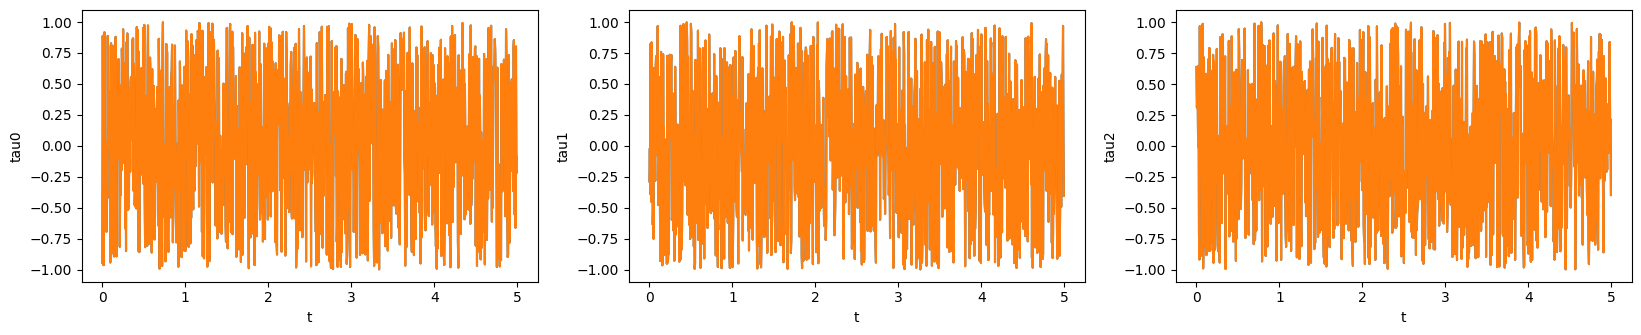

In [52]:
if standardize:
    u_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u]).reshape(num_snaps_val,num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:-1],us_test[:,i], label= 'original')
        plt.plot(T[:-1],u_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))
        
    print(u.shape)
    print(u_unscaled.shape)

## Cartesian Space

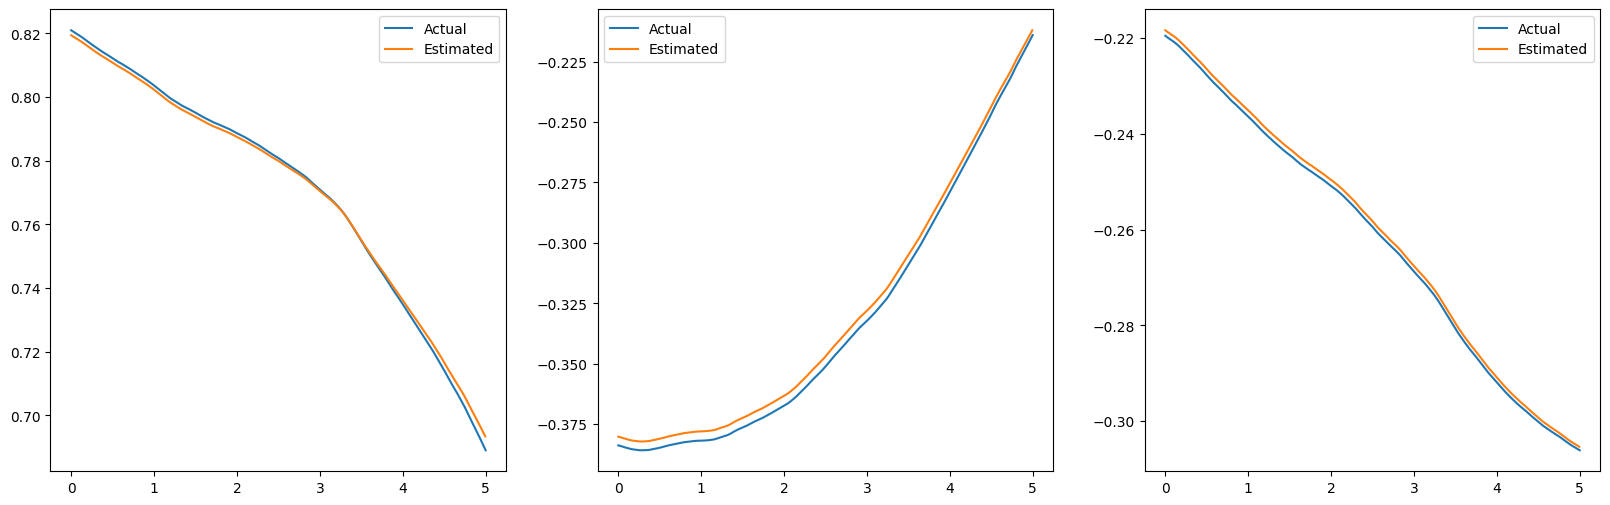

In [53]:
plt.figure(figsize=(20,6))
for i in range(X_end.shape[2]):
    plt.subplot(1,3,i+1)
    plt.plot(T[:],xs_end_test[:,i], label = 'Actual')
    plt.plot(T[:-1],x_end_est[:,i], label = 'Estimated')
    plt.legend()
plt.show()

In [54]:
error_joint_space = np.linalg.norm(xs_test-x_est,axis = 1)
error_cart_space = np.linalg.norm(xs_end_test[:-1]-x_end_est,axis = 1)

Text(0.5, 1.0, 'Cartesian Space Error')

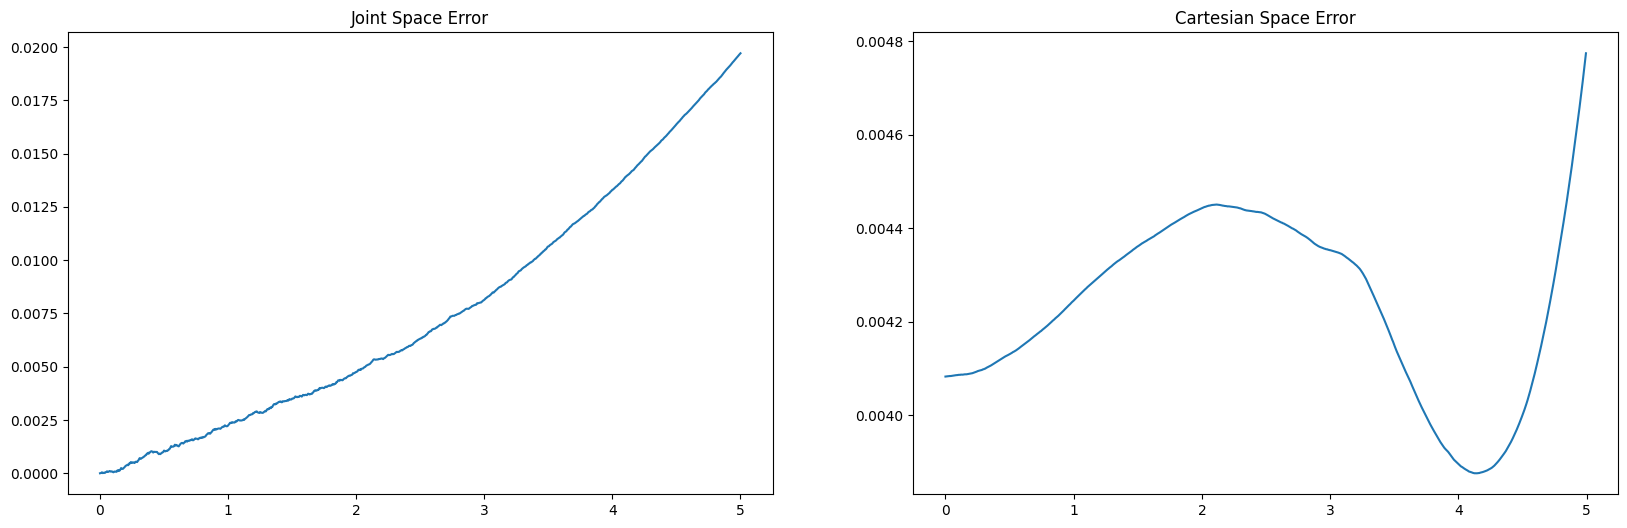

In [55]:
plt.figure(figsize =(20,6))
plt.subplot(1,2,1)
plt.plot(T[:],error_joint_space)
plt.title('Joint Space Error')

plt.subplot(1,2,2)
plt.plot(T[:-1],error_cart_space)
plt.title('Cartesian Space Error')

In [56]:
xs_test[8,:]

array([-0.41343498, -0.03862804, -0.72979163, -0.04770397,  0.0474441 ,
       -0.05561392])

## Controllers

## Reference Trajectory

In [57]:
t_ctrl = np.arange(start=0, stop=5, step=dt)
num_snaps_ctrl = t_ctrl.shape[0]

In [58]:
## linear path
# x_ref = np.vstack((np.vstack((np.linspace(0,np.pi,num_snaps_ctrl),np.linspace(0,np.pi/2,num_snaps_ctrl))),np.linspace(0,np.pi,num_snaps_ctrl)))
# x_ref_dot = np.vstack((np.vstack(((np.pi/10)*np.ones(num_snaps_ctrl),(np.pi/20)*np.ones(num_snaps_ctrl))),(np.pi/10)*np.ones(num_snaps_ctrl)))
# x_ref_ddot = np.vstack((np.vstack((np.zeros(num_snaps_ctrl),np.zeros(num_snaps_ctrl))),np.zeros(num_snaps_ctrl)))

def gen_desired_path(num_states,num_snaps, t_end,shape):
    
    x_ref = np.empty((int(num_states),num_snaps))
    x_ref_dot = np.empty_like(x_ref)
    x_ref_ddot = np.empty_like(x_ref)
    
    arg = np.linspace(0,np.pi,num_snaps)
    
    for i in range(num_snaps):
        if shape == 'linear':
            x_ref[:,i] = np.array([arg[i], arg[i]/2, arg[i]])
            x_ref_dot[:,i] = np.array([arg[-1]/t_end, arg[-1]/(2*t_end), arg[-1]/(t_end)])
            x_ref_ddot[:,i] = np.zeros(num_states,)
            
        elif shape == 'sinosoidal':
            x_ref[:,i] = 0.5*np.array([np.sin(arg[i]),np.sin(arg[i]) , np.sin(arg[i])])
            x_ref_dot[:,i] = 0.5*np.array([(arg[-1]/t_end)*np.cos(arg[i]),(arg[-1]/t_end)*np.cos(arg[i]),
                                      (arg[-1]/t_end)*np.cos(arg[i]),])
            x_ref_ddot[:,i] = 0.5*np.array([-((arg[-1]/t_end)**2)*np.cos(arg[i]),-((arg[-1]/t_end)**2)*np.sin(arg[i]),
                                      -((arg[-1]/t_end)**2)*np.sin(arg[i])])
        else:
            print('Shape is not defined')
            break
            
            
    return x_ref, x_ref_dot, x_ref_ddot



In [59]:
x_ref, x_ref_dot, x_ref_ddot = gen_desired_path(int(num_states/2),num_snaps_ctrl, t_ctrl[-1],'sinosoidal')
# x_ref = x[:,:3].T
# x_ref_dot = x[:,3:].T

## ZNN

In [60]:
gamma = 50

In [61]:
## specify the matricies
z_ctrl = np.empty((n_obs,num_snaps_ctrl))
x_ctrl = np.empty((num_states,num_snaps_ctrl))
u_ctrl = np.empty((num_inputs,num_snaps_ctrl-1))
x_end = np.empty((num_states_cart,num_snaps_ctrl))
x_end_dot = np.empty((num_states_cart,num_snaps_ctrl-1))

## initialize the matricies
x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
x_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()
    

In [62]:
x_ref_full = np.vstack((x_ref,x_ref_dot))
x_ref_dot_full = np.vstack((x_ref_dot,x_ref_ddot))
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(C,Bc)), -np.matmul(C,np.matmul(Ac,z_ctrl[:,i])) + x_ref_dot_full[:,i] - gamma*(x_ctrl[:,i] - x_ref_full[:,i]))
                  
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    z_ctrl_dot = np.matmul(z_ctrl[:,i],Ac.T)+np.matmul(u_ctrl[:,i],Bc.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T) 
    x_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    W = neural_jacobian(map_net,x_ctrl[:num_joints,i] )
    x_end_dot[:, i] = np.matmul(W,x_ctrl[num_joints:,i])
    
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [63]:
u_ctrl[:,i]

array([-0.06919738, -0.05395495,  0.00395037])

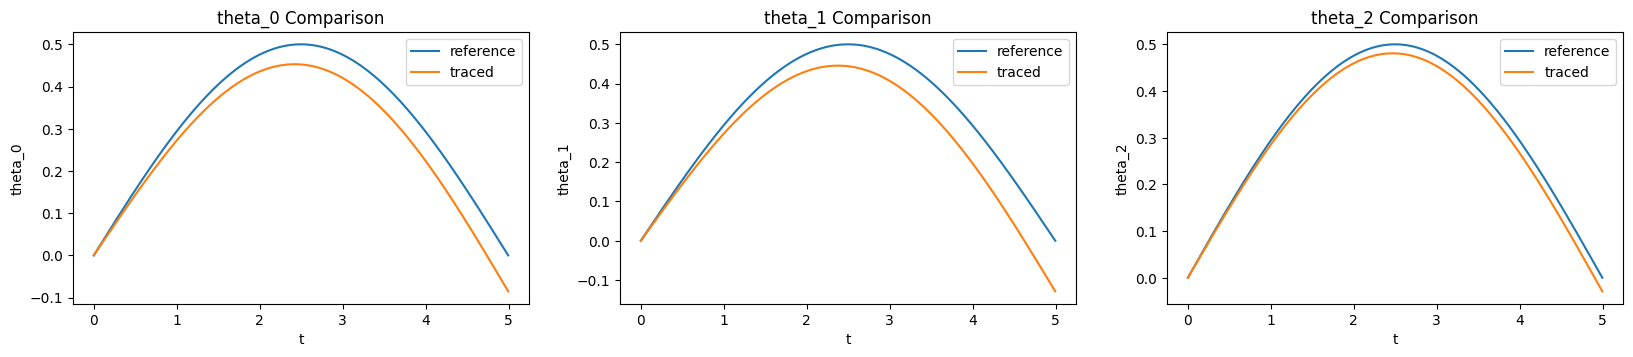

In [64]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:],x_ref[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl[i,:],label = 'traced')
    plt.xlabel('t')
    plt.ylabel('theta_' + str(i))
    plt.title('theta_' + str(i) + ' Comparison')
    plt.legend()

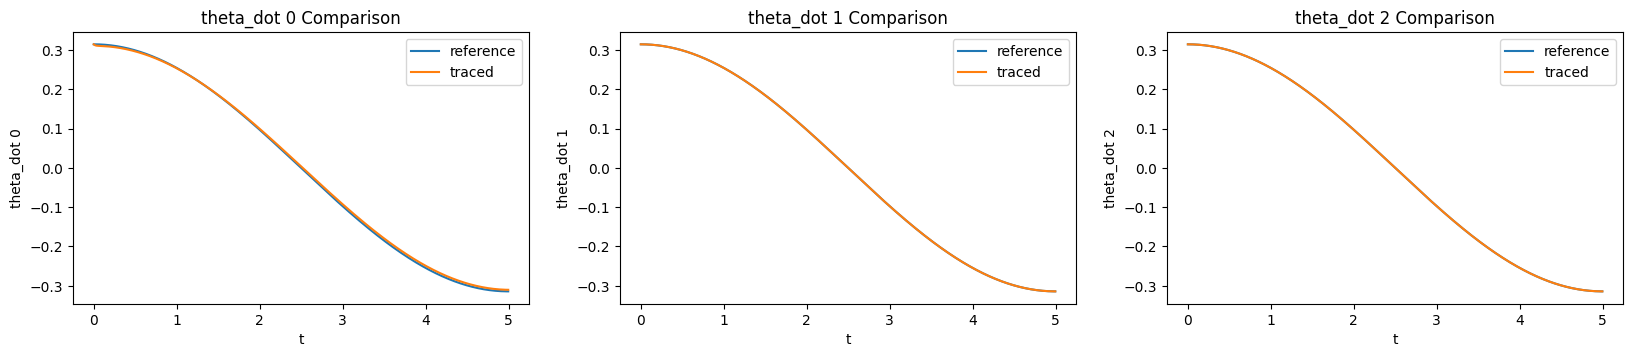

In [65]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:],x_ref_dot[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl[int(i+num_joints),:],label = 'traced')
    plt.xlabel('t')
    plt.ylabel('theta_dot ' + str(i))
    plt.title('theta_dot ' + str(i) + ' Comparison')
    plt.legend()

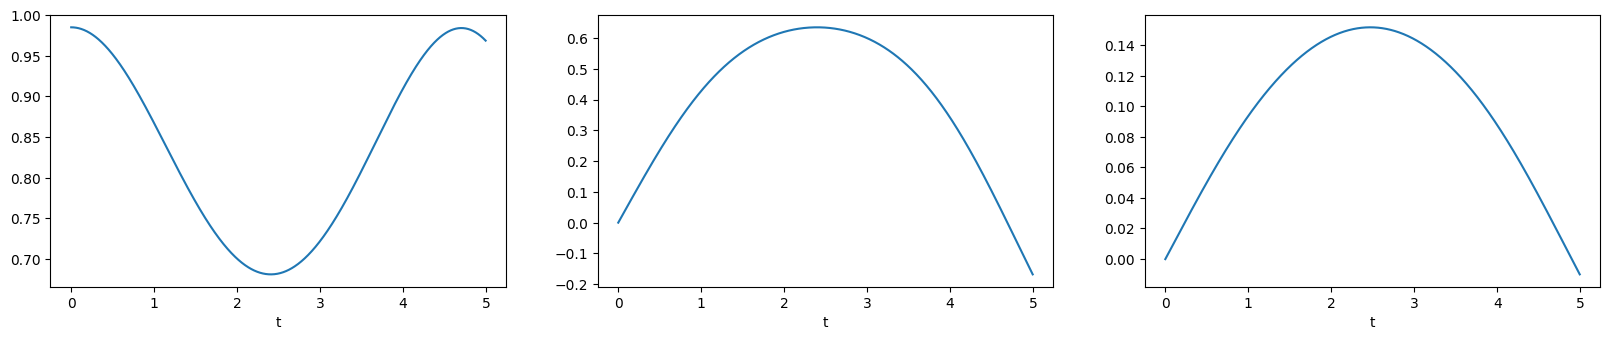

In [66]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:],x_end[i,:],label ='reference')
    plt.xlabel('t')
    

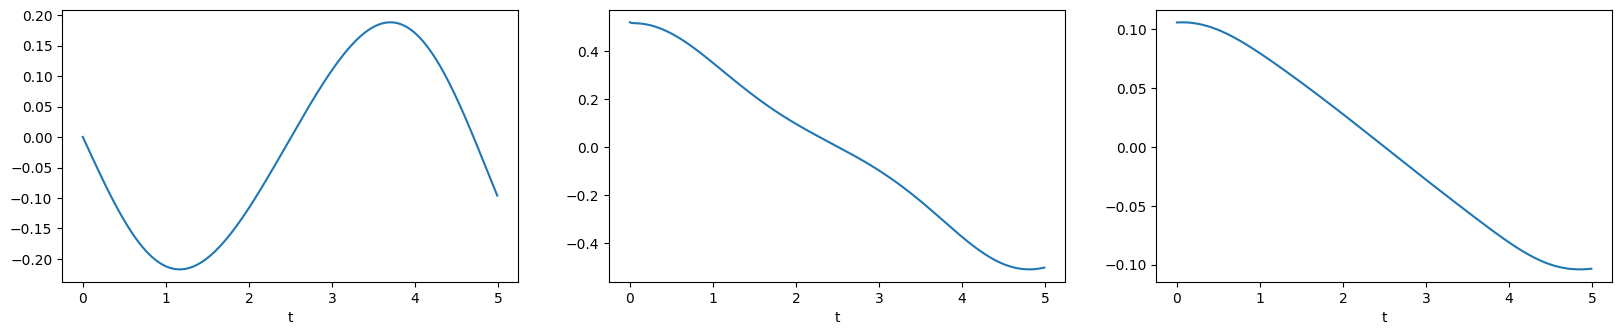

In [67]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],x_end_dot[i,:],label ='reference')
    plt.xlabel('t')

(0.6658886134624481,
 1.0001564562320708,
 -0.2084146708250046,
 0.6750436395406723)

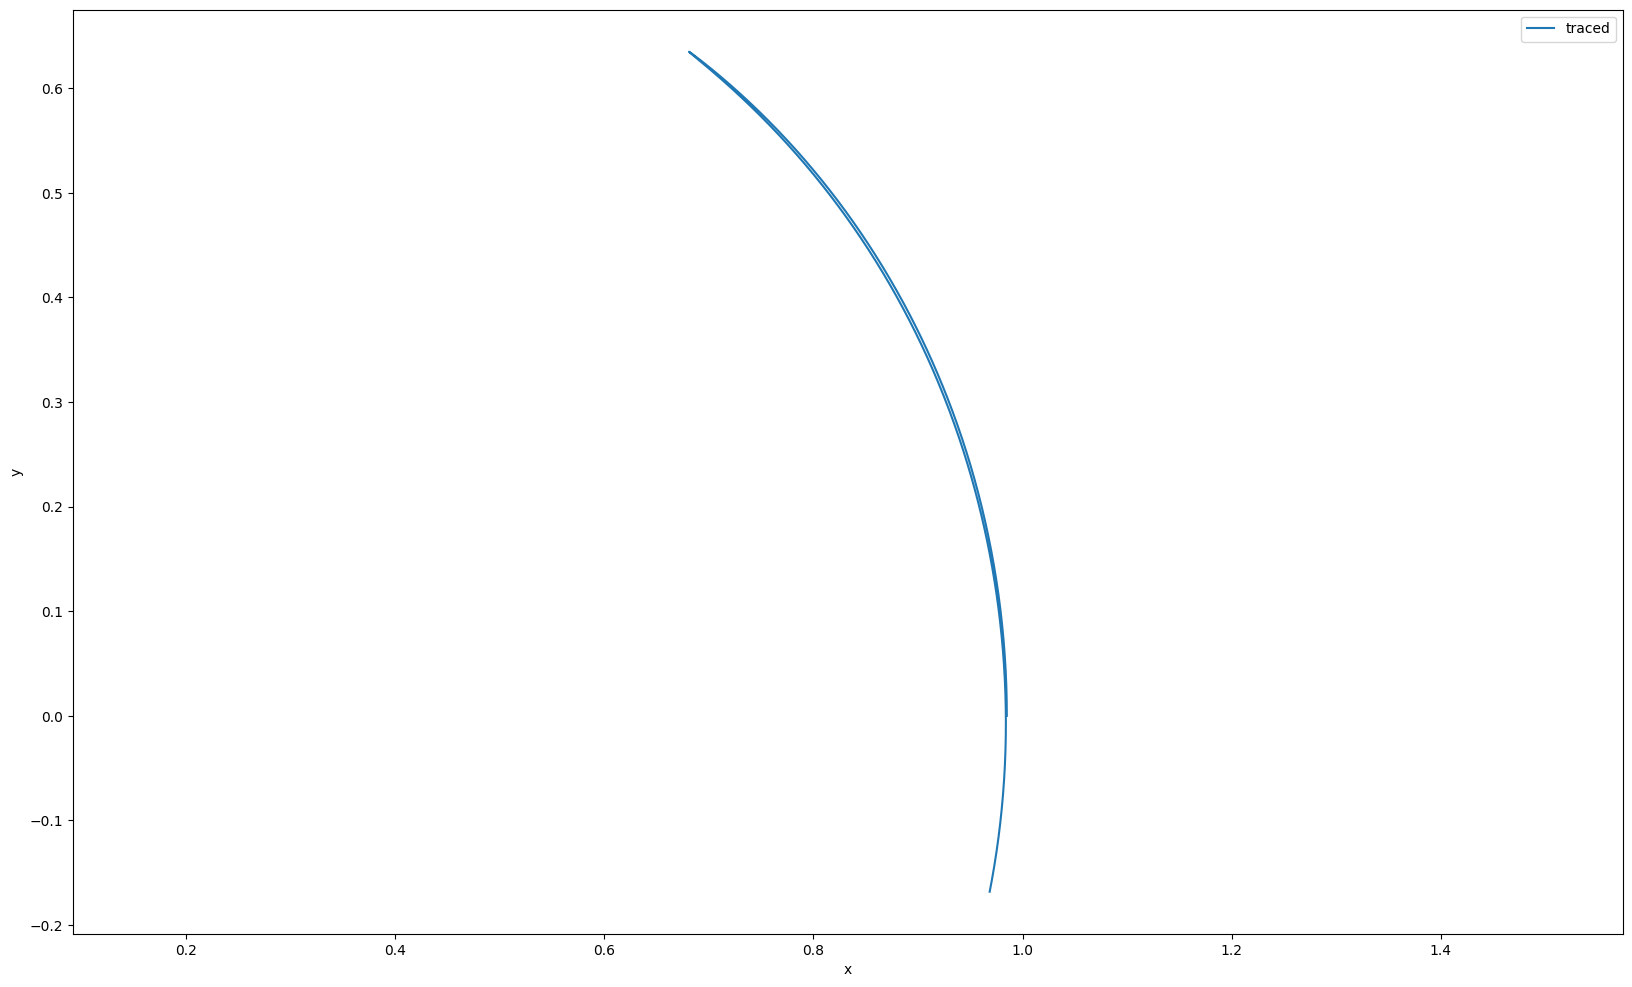

In [68]:
plt.figure(figsize=(20,12))
plt.plot(x_end[0,:],x_end[1,:],label = 'traced')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')

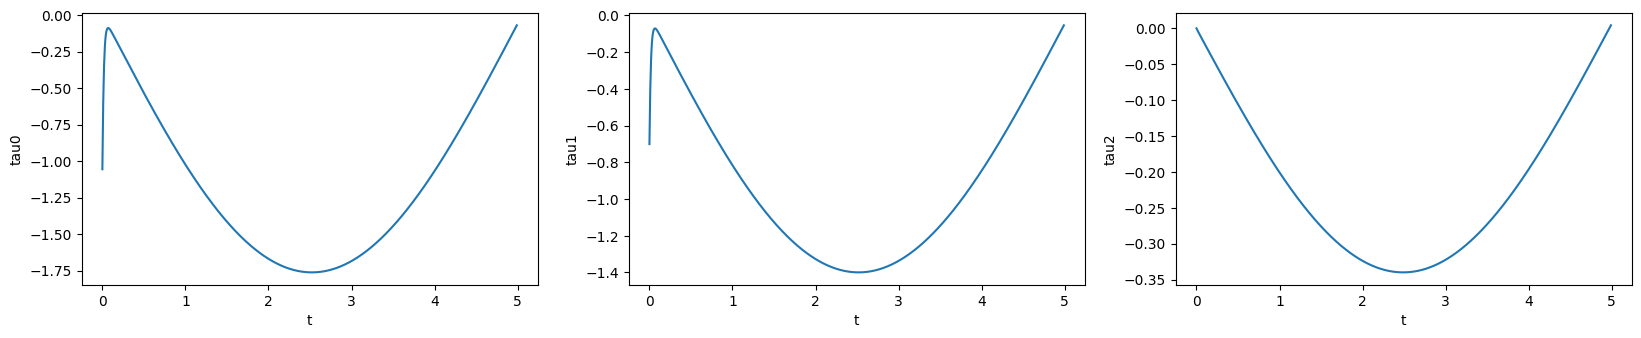

In [69]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

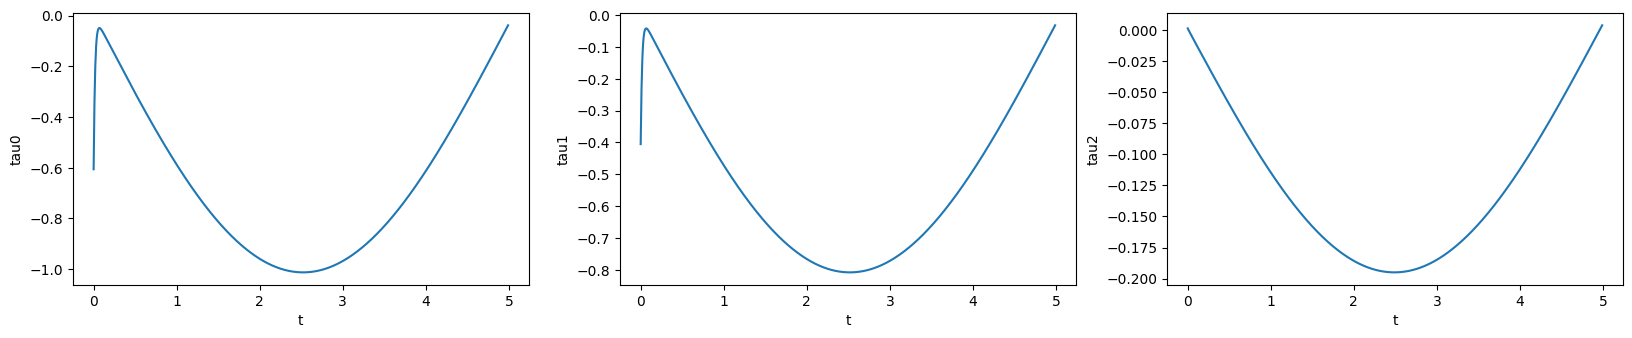

In [70]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(num_snaps_val-1,num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:-2],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

In [71]:
u_ctrl.shape

(3, 999)

## ZNN Cartesian Space

In [72]:
gamma = 1
shape = 'cardioid'
c = 0.1
tilt = 0

In [73]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states_cart,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl-1))

## initialize the matricies
x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0])) 
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()

In [74]:

# for i in range(num_snaps_ctrl-1):
#     t = t_ctrl[i]
#     if modality == '2D':
#         # rd[:,i], rd_dot[:,i],_ = path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
#         rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
#     else:
#         rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        
#     error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
#     W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
#     if i == 0:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,0]))) + rd_dot[:,i] - gamma*(error[:,i]))
#     else:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,i-1]))) + rd_dot[:,i] - gamma*(error[:,i]))
        
#     u_ctrl[:,i+1] = u_ctrl[:,i] + u_dot*dt 
                  
#     z_dot[:,i] = np.matmul(z_ctrl[:,i],Ac.T)+np.matmul(u_ctrl[:,i],Bc.T)
#     z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
#     x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
#     x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
#     # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
#     # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [75]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        # rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
        
    #u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, Bc))), -np.matmul(W, np.matmul(Cr,np.matmul(Ac,z_ctrl[:,i]))) + rd_dot[:,i] - gamma*(error[:,i]))
    u_ctrl[:,i] = np.dot(np.linalg.pinv(Bc), -np.matmul(Ac,z_ctrl[:,i]) + np.matmul(np.linalg.pinv(np.matmul(W,Cr)),rd_dot[:,i] - gamma*(error[:,i])))
                  
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [76]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[   643384.8  ,   -175720.45 , -11478848.   ],
       [   -30778.014,    -58904.95 ,   3670613.8  ],
       [   219449.25 ,   -104393.53 ,  -5131072.   ]], dtype=float32)

In [77]:
W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
W_dot = neural_jacobian_dot(map_net, x_ctrl[:num_joints,i],x_ctrl[num_joints:,i])

J_tilde = np.vstack((np.hstack((W,np.zeros_like(W))),np.hstack((W_dot,W))))



(-0.3597107008099556,
 1.048994518816471,
 -0.2103339359164238,
 0.8354602083563805)

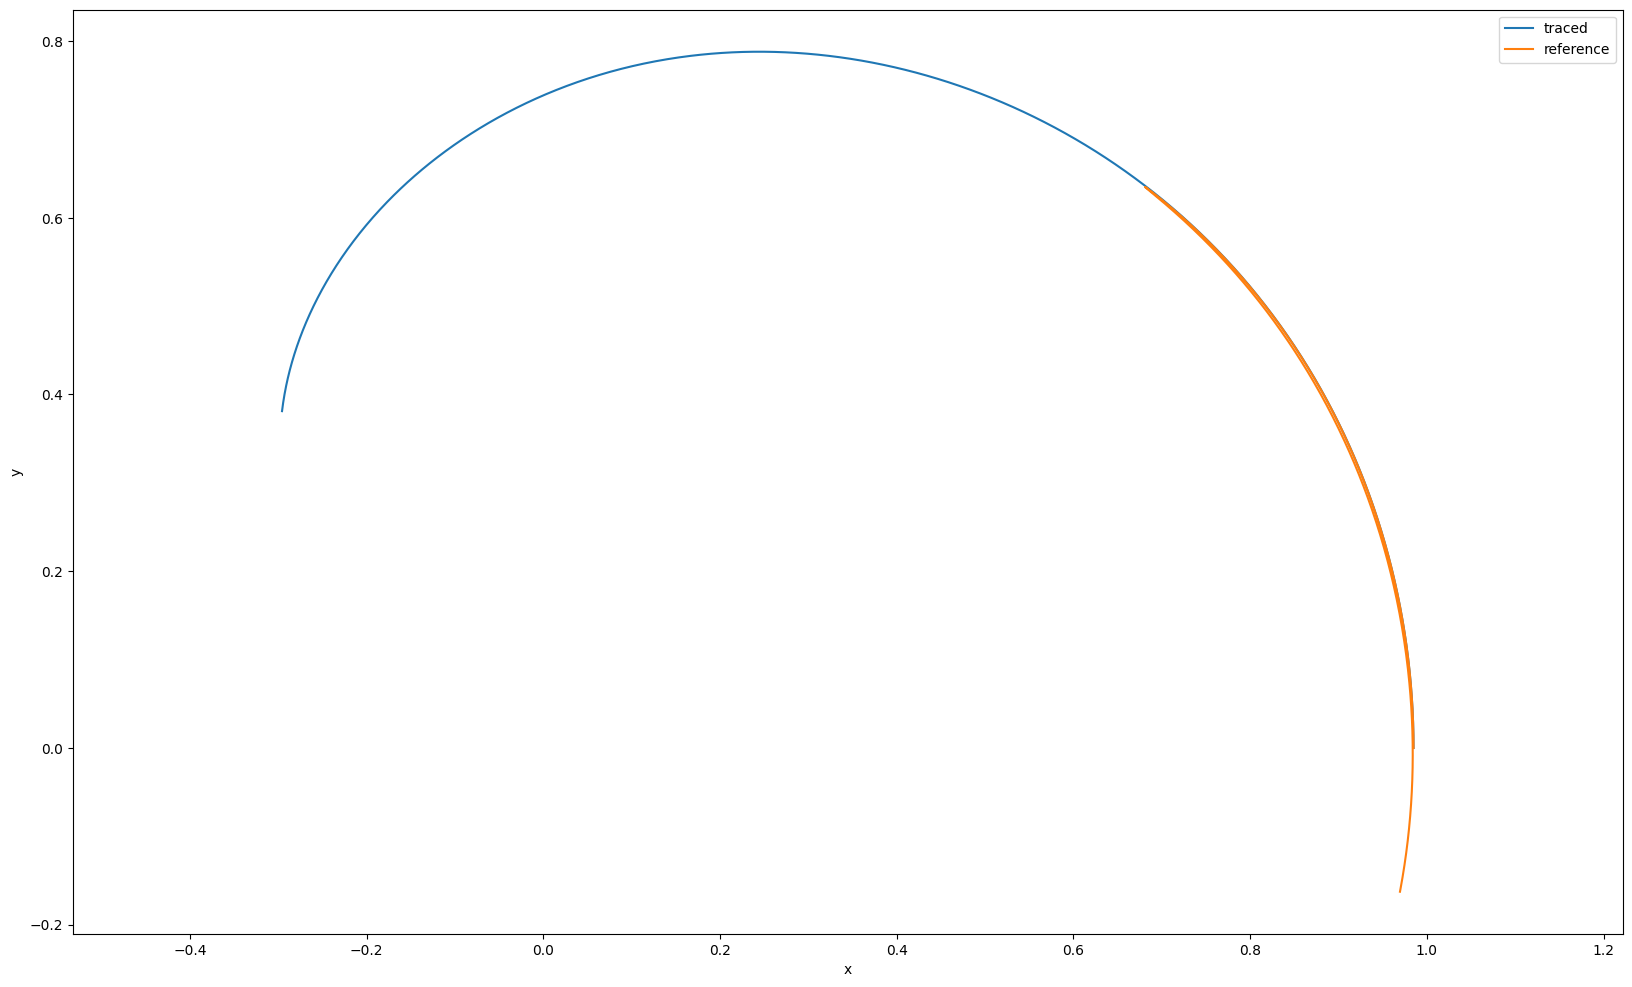

In [78]:
plt.figure(figsize=(20,12))
plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')

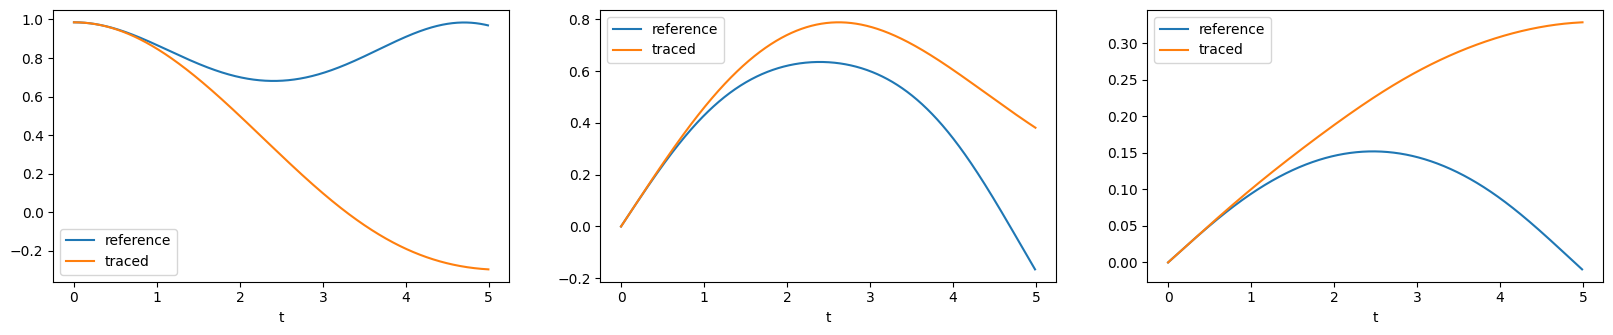

In [79]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

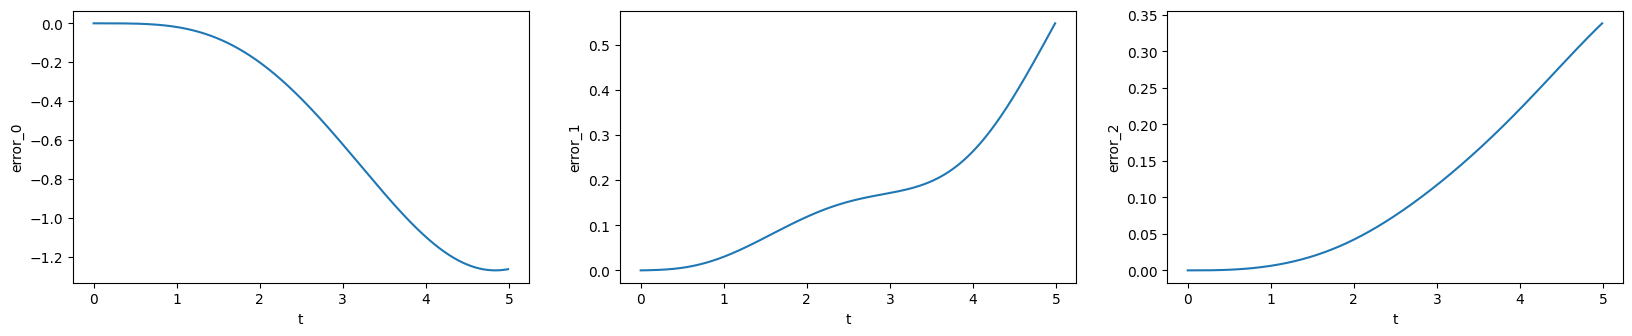

In [80]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

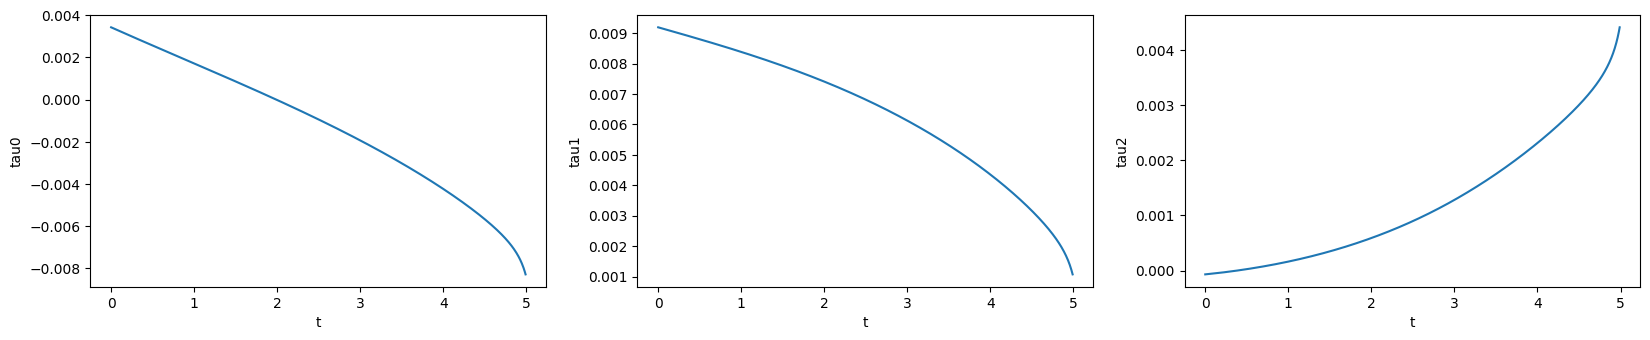

In [81]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

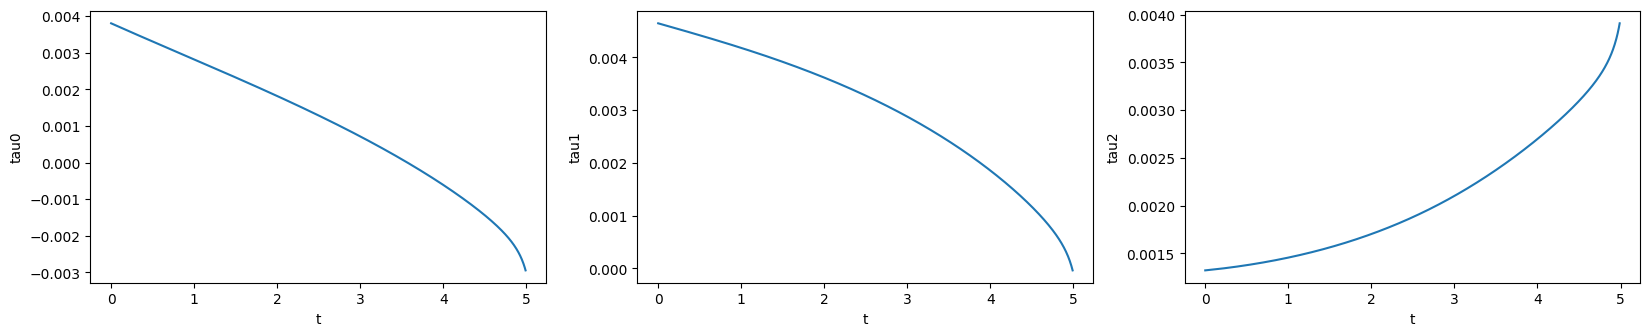

In [82]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

## ZNN self feedback

In [83]:
gamma = 1
shape = 'cardioid'
c = 0.1
tilt = 0

In [84]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states_cart,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl))

## initialize the matricies
x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0])) 
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()

In [85]:

# for i in range(num_snaps_ctrl-1):
#     t = t_ctrl[i]
#     if modality == '2D':
#         # rd[:,i], rd_dot[:,i],_ = path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
#         rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
#     else:
#         rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        
#     error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
#     W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
#     if i == 0:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,0]))) + rd_dot[:,i] - gamma*(error[:,i]))
#     else:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,i-1]))) + rd_dot[:,i] - gamma*(error[:,i]))
        
#     u_ctrl[:,i+1] = u_ctrl[:,i] + u_dot*dt 
                  
#     z_dot[:,i] = np.matmul(z_ctrl[:,i],Ac.T)+np.matmul(u_ctrl[:,i],Bc.T)
#     z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
#     x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
#     x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
#     # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
#     # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [86]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        # rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
        
    #u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, Bc))), -np.matmul(W, np.matmul(Cr,np.matmul(Ac,z_ctrl[:,i]))) + rd_dot[:,i] - gamma*(error[:,i]))
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(Bc), -np.matmul(Ac,z_ctrl[:,i]) + np.matmul(np.linalg.pinv(np.matmul(W,Cr)),rd_dot[:,i] - gamma*(error[:,i])))
    u_ctrl[:,i+1] = -np.matmul(np.matmul(W,Cr),np.matmul(Bc,u_ctrl[:,i])) + u_ctrl[:,i] - np.matmul(np.matmul(W,Cr),np.matmul(Ac,z_ctrl[:,i])) + rd_dot[:,i] - gamma*(error[:,i])
                  
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [87]:
 u_ctrl[:,i]

array([774.2441809 , 584.55781782,  83.39291774])

In [88]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[-2.5960064e+13, -1.3186459e+13,  3.8158700e+13],
       [ 2.8324271e+12,  1.1146562e+12,  5.1589861e+12],
       [-7.3639810e+12, -3.7663411e+12,  1.1566312e+13]], dtype=float32)

(-0.5175702571868896,
 1.056511640548706,
 -1.2715211093425751,
 1.5855654656887055)

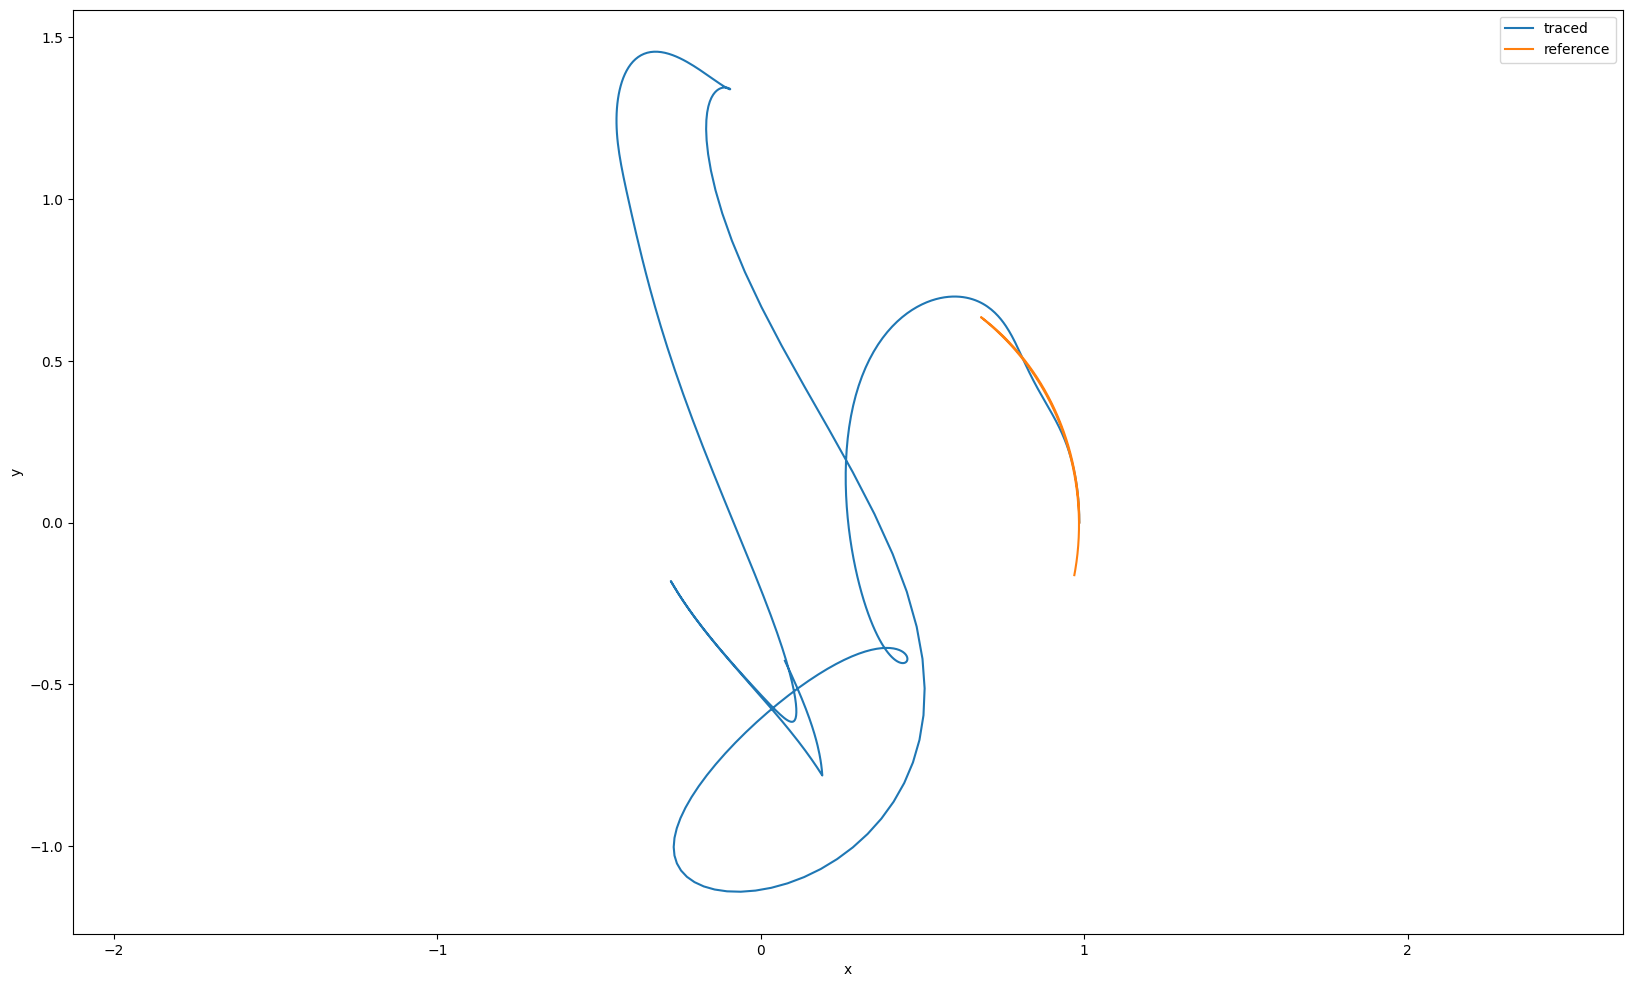

In [89]:
plt.figure(figsize=(20,12))
plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')

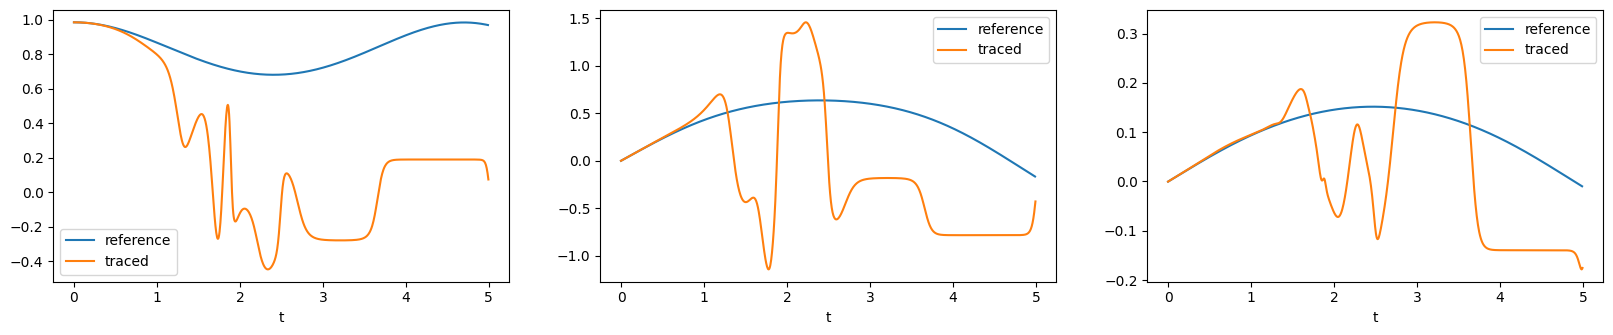

In [90]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

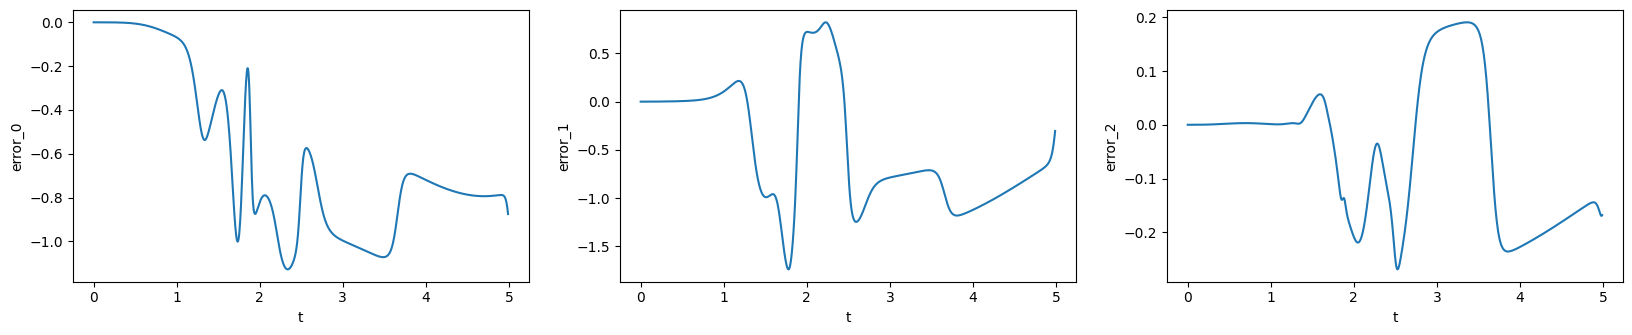

In [91]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

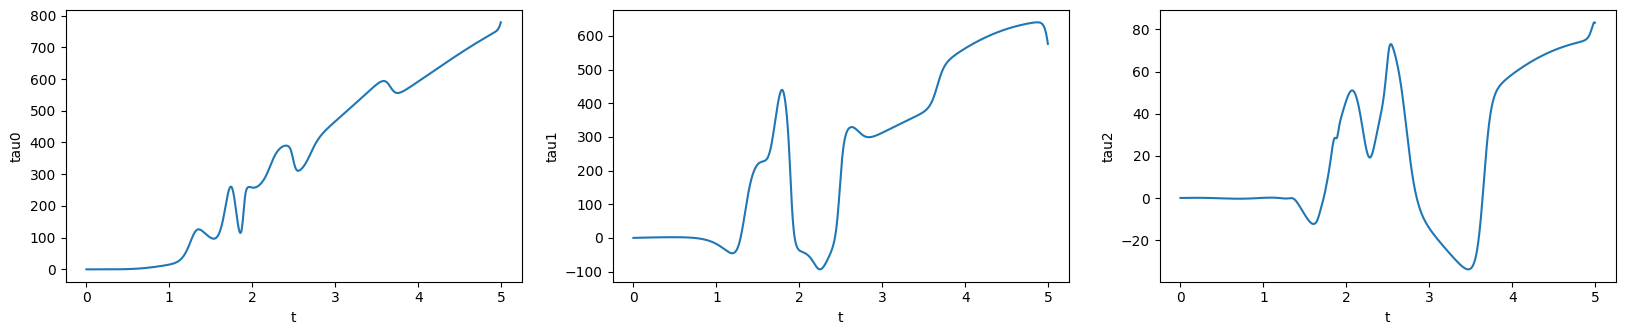

In [92]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

## ZNN velocitye reduced

In [93]:
gamma = 10
shape = 'cardioid'
c = 0.01
tilt = np.pi/6

In [94]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states_cart,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl))

## initialize the matricies
# x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
x_ctrl[:,0] = np.hstack((np.ones((num_joints,)), np.zeros((num_joints,))))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()

In [95]:

# for i in range(num_snaps_ctrl-1):
#     t = t_ctrl[i]
#     if modality == '2D':
#         # rd[:,i], rd_dot[:,i],_ = path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
#         rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
#     else:
#         rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        
#     error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
#     W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
#     if i == 0:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,0]))) + rd_dot[:,i] - gamma*(error[:,i]))
#     else:
#         u_dot = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr, B))), -np.matmul(W, np.matmul(Cr,np.matmul(A,z_dot[:,i-1]))) + rd_dot[:,i] - gamma*(error[:,i]))
        
#     u_ctrl[:,i+1] = u_ctrl[:,i] + u_dot*dt 
                  
#     z_dot[:,i] = np.matmul(z_ctrl[:,i],Ac.T)+np.matmul(u_ctrl[:,i],Bc.T)
#     z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
#     x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
#     x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
#     # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
#     # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [96]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        rd[:,i], rd_dot[:,i],_ = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        # rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    error[:,i] = x_ctrl_end[:,i] - rd[:,i]
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
        
    u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(W,np.matmul(Cr_v, B))), -np.matmul(W, np.matmul(Cr_v,np.matmul(A,z_ctrl[:,i]))) + rd_dot[:,i] - gamma*(error[:,i]))
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(Bc), -np.matmul(Ac,z_ctrl[:,i]) + np.matmul(np.linalg.pinv(np.matmul(W,Cr)),rd_dot[:,i] - gamma*(error[:,i])))
    # u_ctrl[:,i+1] = -np.matmul(np.matmul(W,Cr),np.matmul(Bc,u_ctrl[:,i])) + u_ctrl[:,i] - np.matmul(np.matmul(W,Cr),np.matmul(Ac,z_ctrl[:,i])) + rd_dot[:,i] - gamma*(error[:,i])
            
    
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [97]:
 u_ctrl[:,i]

array([-0.03048162, -0.20880188, -0.00367021])

In [98]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[ 290363.9  , -634375.7  , -902231.   ],
       [ -33050.34 ,  -63004.547,  222489.6  ],
       [  81515.67 , -237549.27 , -422475.28 ]], dtype=float32)

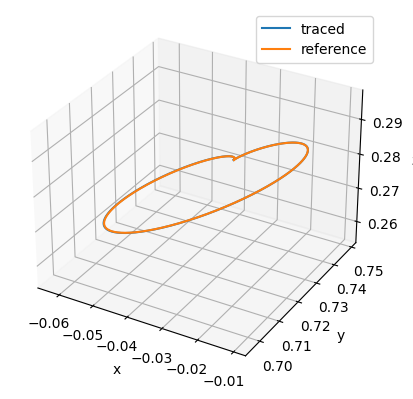

In [99]:
if modality == '2D':
    plt.figure(figsize=(20,12))
    plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
    plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
else:
    ax = plt.axes(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.plot3D(x_ctrl_end[0,:],x_ctrl_end[1,:],x_ctrl_end[2,:],label = 'traced')
    ax.plot3D(rd[0,:-1],rd[1,:-1],rd[2,:-1],label ='reference')
    plt.legend()

    plt.axis('equal')
    


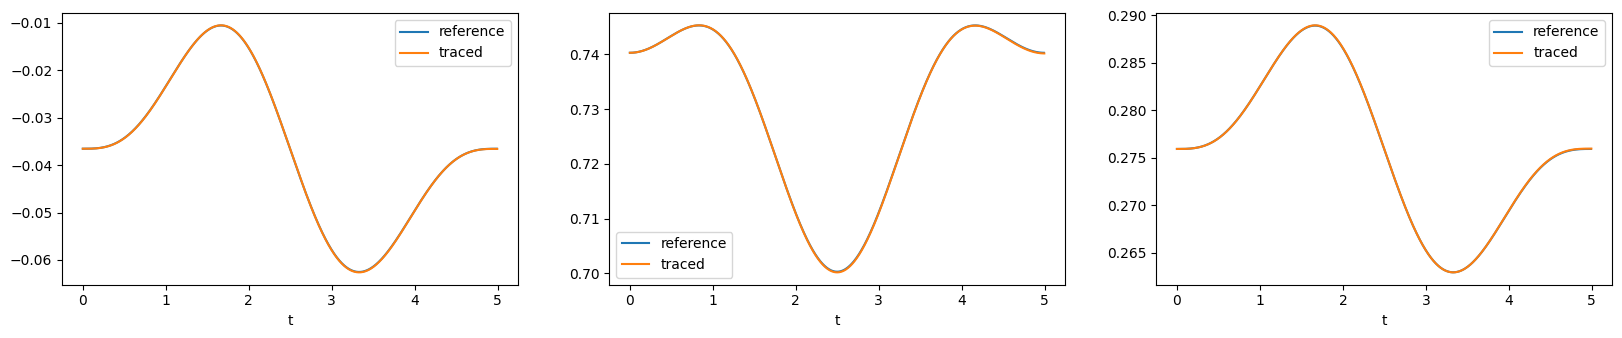

In [100]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

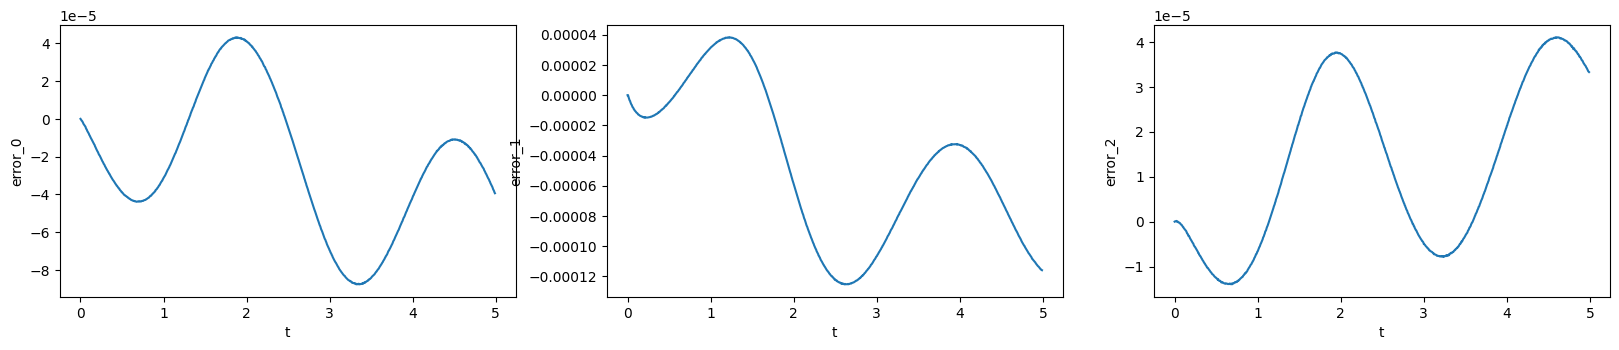

In [101]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

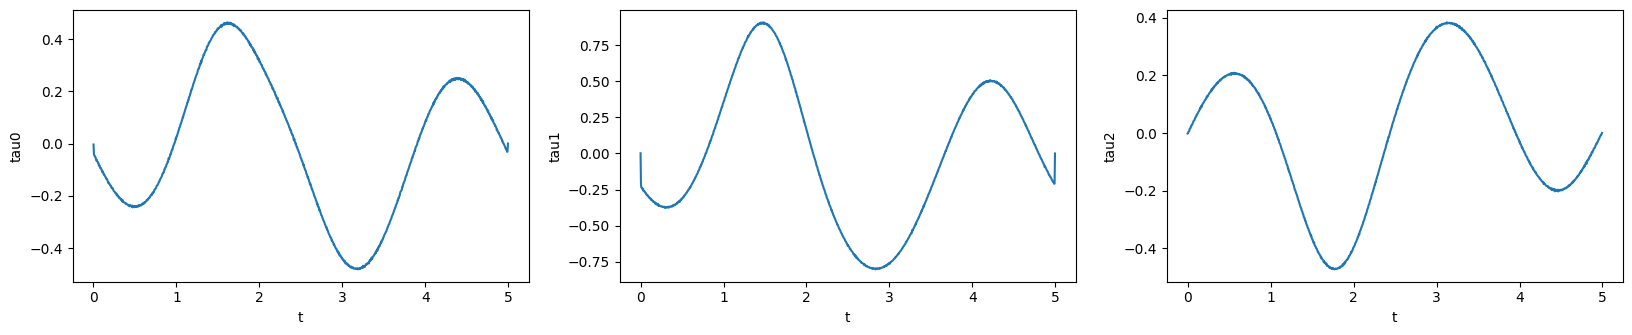

In [102]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

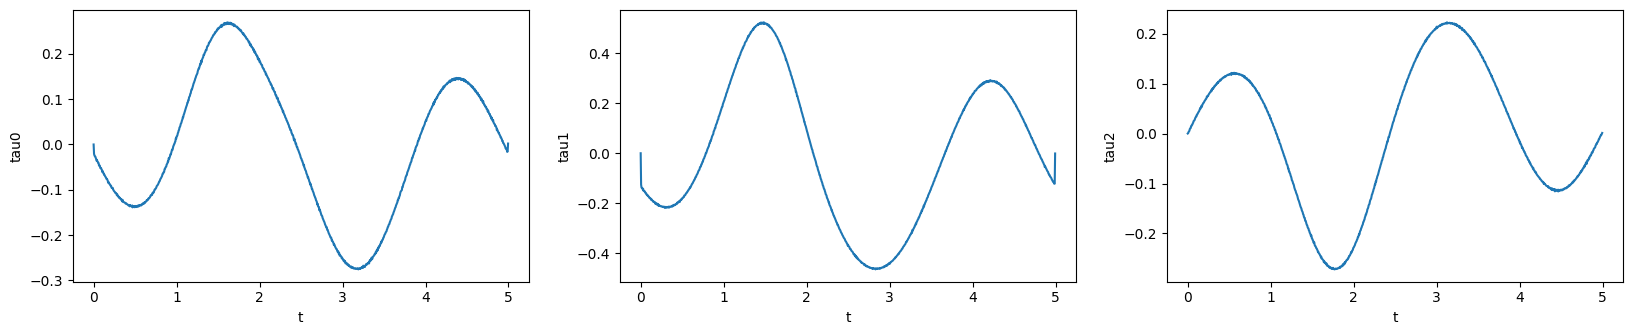

In [103]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

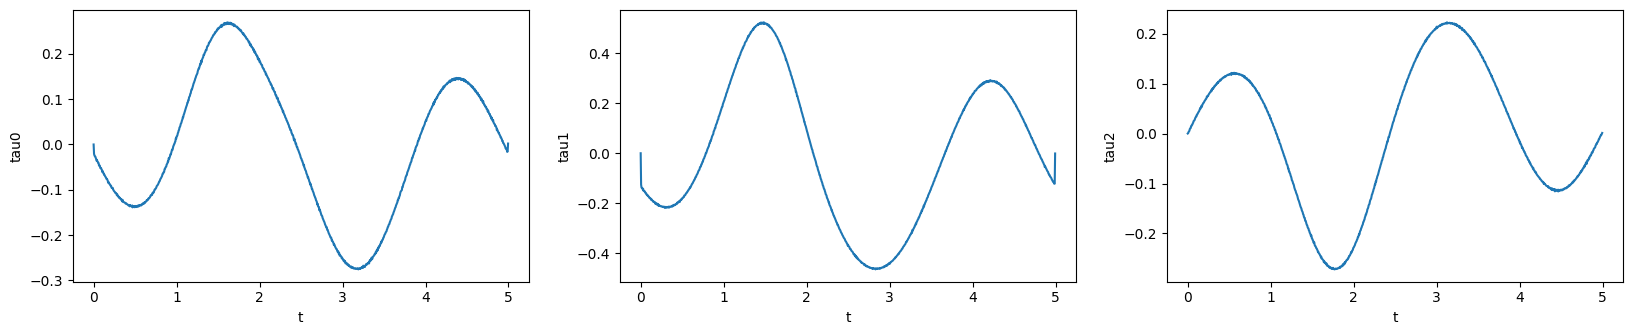

In [104]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

## ZNN full state

In [174]:
gamma = np.diag([10,10,10,10,10,10])
shape = 'petal'
c = 0.02
tilt = np.pi/6

In [175]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_ddot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl))

## initialize the matricies
# x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
x_ctrl[:,0] = np.hstack((np.ones((num_joints,)), np.zeros((num_joints,))))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()


In [176]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        rd[:,i], rd_dot[:,i], rd_ddot[:,i] = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        # rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    rd_full = np.hstack((rd[:,i], rd_dot[:,i]))
    rd_dot_full = np.hstack((rd_dot[:,i], rd_ddot[:,i]))
    error[:,i] = np.hstack((x_ctrl_end[:,i],x_ctrl_dot_end[:,i])) - rd_full
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
    W_dot = neural_jacobian_dot(map_net, x_ctrl[:num_joints,i],x_ctrl[num_joints:,i])
    J_tilde = np.vstack((np.hstack((W,np.zeros_like(W))),np.hstack((W_dot,W))))
    
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(Bc), -np.matmul(Ac,z_ctrl[:,i]) + np.matmul(np.linalg.pinv(np.matmul(J_tilde, Cc)), (rd_dot_full - np.matmul(gamma,error[:,i]))))
    
    u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,Bc))), -np.matmul(np.matmul(J_tilde, Cc),np.matmul(Ac,z_ctrl[:,i])) + rd_dot_full - np.matmul(gamma,error[:,i]))
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(Cc,Bc)), -np.matmul(np.matmul(Cc,Ac),z_ctrl[:,i]) + np.matmul(np.linalg.pinv(J_tilde), (rd_dot_full - np.matmul(gamma,error[:,i]))))
            
    
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    x_ctrl_dot_end[:,i+1] = np.matmul(neural_jacobian(map_net, x_ctrl[:num_joints,i+1]), x_ctrl[num_joints:,i+1])
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

ValueError: could not broadcast input array from shape (3,6) into shape (3,)

In [166]:
(rd_dot_full - gamma*(error[:,i])).shape

(6,)

In [167]:
np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,B))).mean()

-143.65688

In [168]:
np.matmul(np.matmul(J_tilde, Cc),A).mean()

-0.017511494

In [169]:
u_ctrl[:,10]

array([0.01172111, 1.58574945, 0.21900521])

In [170]:
np.matmul(J_tilde,Cc).shape

(6, 27)

In [171]:
np.vstack((rd_dot[:,i], rd_ddot[:,i]))

array([[-0.05030286,  0.00158221, -0.02515143],
       [-0.00517464, -0.31640862, -0.00258732]])

In [172]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[ 292365.44 , -629235.56 , -904684.75 ],
       [ -33138.418,  -62557.42 ,  225049.67 ],
       [  82161.33 , -235701.45 , -423727.34 ]], dtype=float32)

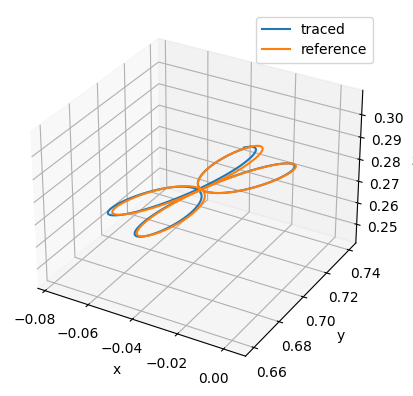

In [173]:
if modality == '2D':
    plt.figure(figsize=(20,12))
    plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
    plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
else:
    ax = plt.axes(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.plot3D(x_ctrl_end[0,:],x_ctrl_end[1,:],x_ctrl_end[2,:],label = 'traced')
    ax.plot3D(rd[0,:-1],rd[1,:-1],rd[2,:-1],label ='reference')
    plt.legend()

    plt.axis('equal')
    


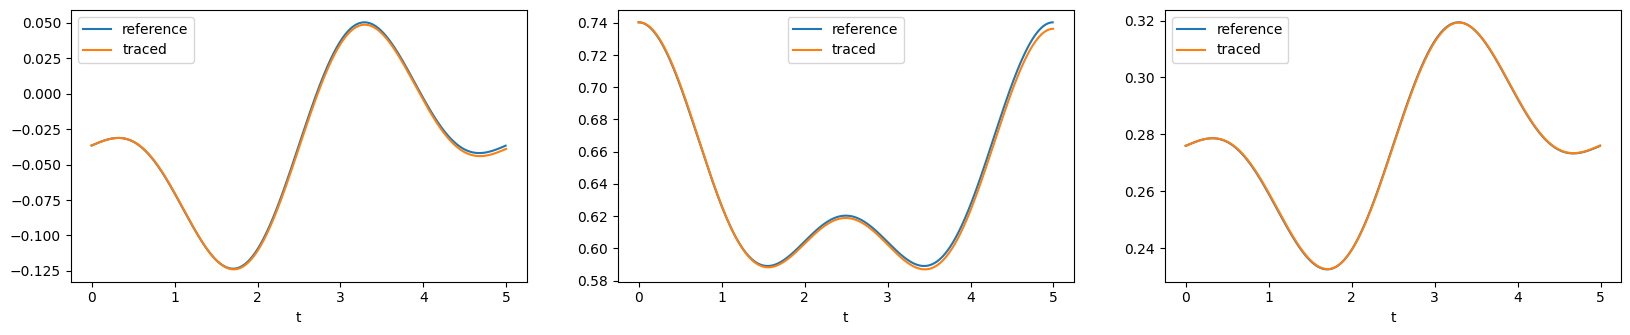

In [116]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

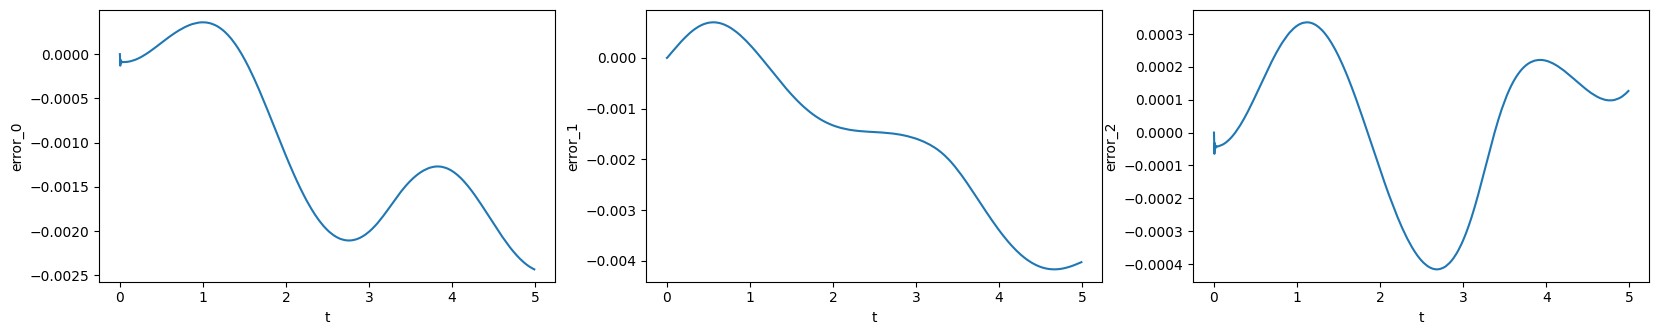

In [117]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

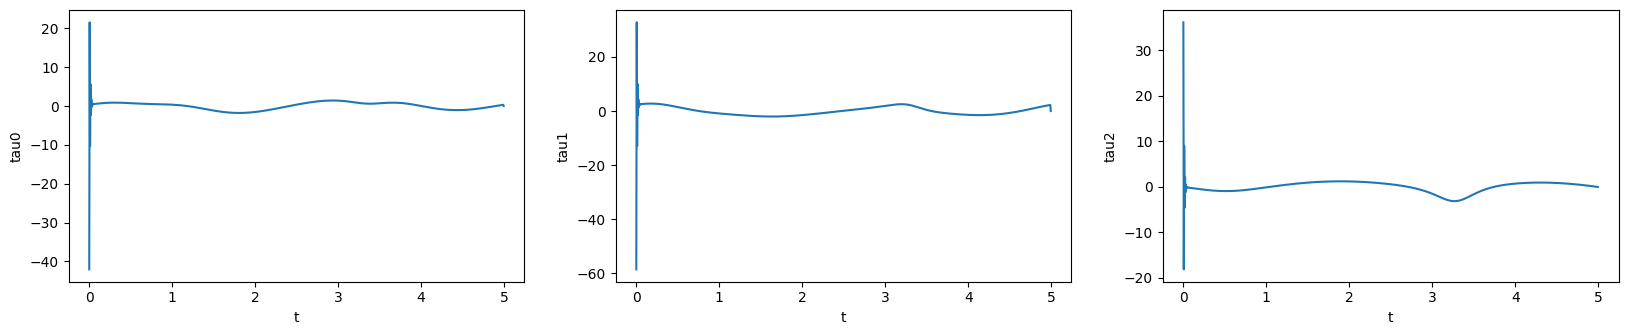

In [118]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

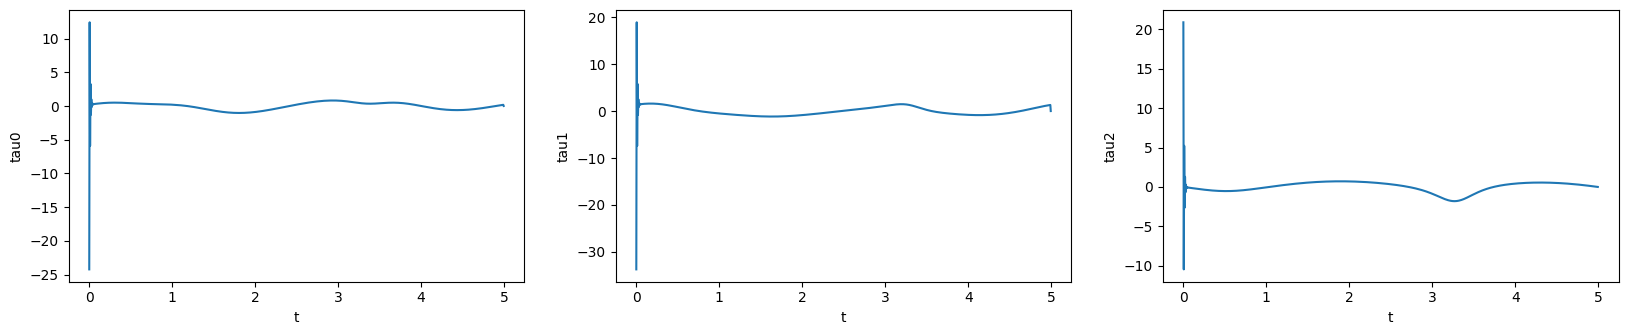

In [119]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

## ZNN full u dot

In [120]:
gamma = 100
shape = 'cardioid'
c = 0.01
tilt = np.pi/6

In [121]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_ddot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl))

## initialize the matricies
# x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
x_ctrl[:,0] = np.hstack((np.ones((num_joints,)), np.zeros((num_joints,))))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
z_dot[:,0] = z_ctrl[:,i+1] = np.matmul(z_ctrl[:,0],Ac.T)+np.matmul(u_ctrl[:,0],Bc.T)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()


In [122]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        rd[:,i], rd_dot[:,i], rd_ddot[:,i] = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        # rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    rd_full = np.hstack((rd[:,i], rd_dot[:,i]))
    rd_dot_full = np.hstack((rd_dot[:,i], rd_ddot[:,i]))
    error[:,i] = np.hstack((x_ctrl_end[:,i],x_ctrl_dot_end[:,i])) - rd_full
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
    W_dot = neural_jacobian_dot(map_net, x_ctrl[:num_joints,i],x_ctrl[num_joints:,i])
    J_tilde = np.vstack((np.hstack((W,np.zeros_like(W))),np.hstack((W_dot,W))))
    
    u_dot = np.dot(np.linalg.pinv(B), -np.matmul(A,z_dot[:,i]) + np.matmul(np.linalg.pinv(np.matmul(J_tilde, Cc)), (rd_dot_full - gamma*(error[:,i]))))
    
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,Bc))), -np.matmul(np.matmul(J_tilde, Cc),np.matmul(Ac,z_ctrl[:,i])) + rd_dot_full - gamma*(error[:,i]))
            
    if i < num_snaps_ctrl:
        u_ctrl[:,i+1] = u_ctrl[:,i] + u_dot*dt
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    x_ctrl_dot_end[:,i+1] = np.matmul(neural_jacobian(map_net, x_ctrl[:num_joints,i+1]), x_ctrl[num_joints:,i+1])
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [123]:
(rd_dot_full - gamma*(error[:,i])).shape

(6,)

In [124]:
np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,B))).mean()

0.0

In [125]:
np.matmul(np.matmul(J_tilde, Cc),A).mean()

0.0

In [126]:
u_ctrl[:,10]

array([-0.12567712,  0.08013879,  0.10711661])

In [127]:
np.matmul(J_tilde,Cc).shape

(6, 27)

In [128]:
np.vstack((rd_dot[:,i], rd_ddot[:,i]))

array([[ 1.49275052e-06, -1.58222670e-04,  7.46375262e-07],
       [-5.97090368e-04,  3.16416131e-02, -2.98545184e-04]])

In [129]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

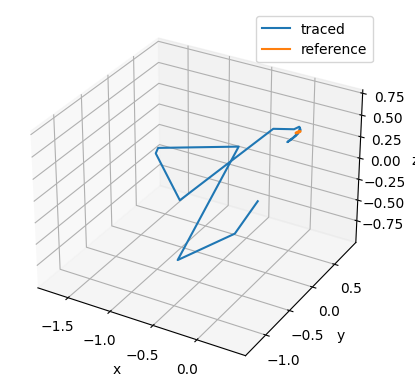

In [130]:
if modality == '2D':
    plt.figure(figsize=(20,12))
    plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
    plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
else:
    ax = plt.axes(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.plot3D(x_ctrl_end[0,:],x_ctrl_end[1,:],x_ctrl_end[2,:],label = 'traced')
    ax.plot3D(rd[0,:-1],rd[1,:-1],rd[2,:-1],label ='reference')
    plt.legend()

    plt.axis('equal')
    


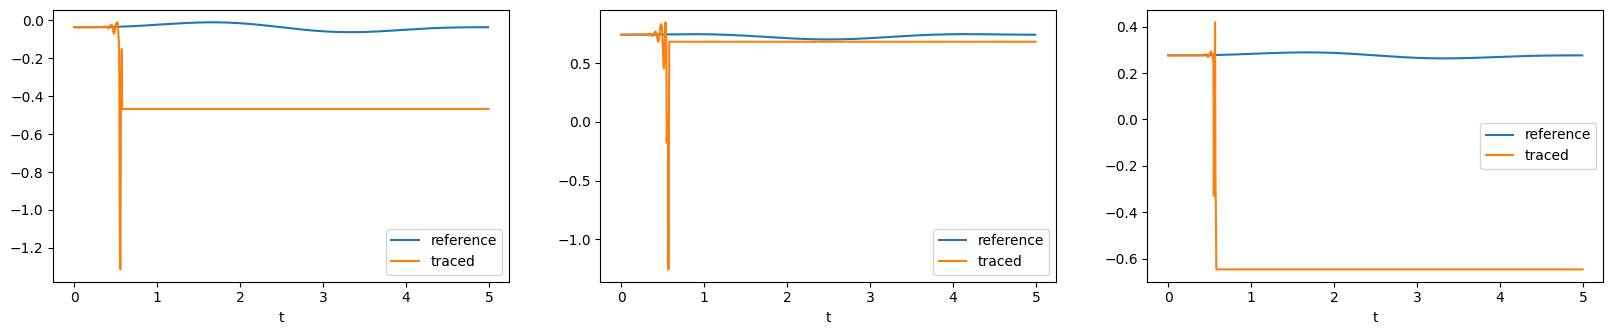

In [131]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

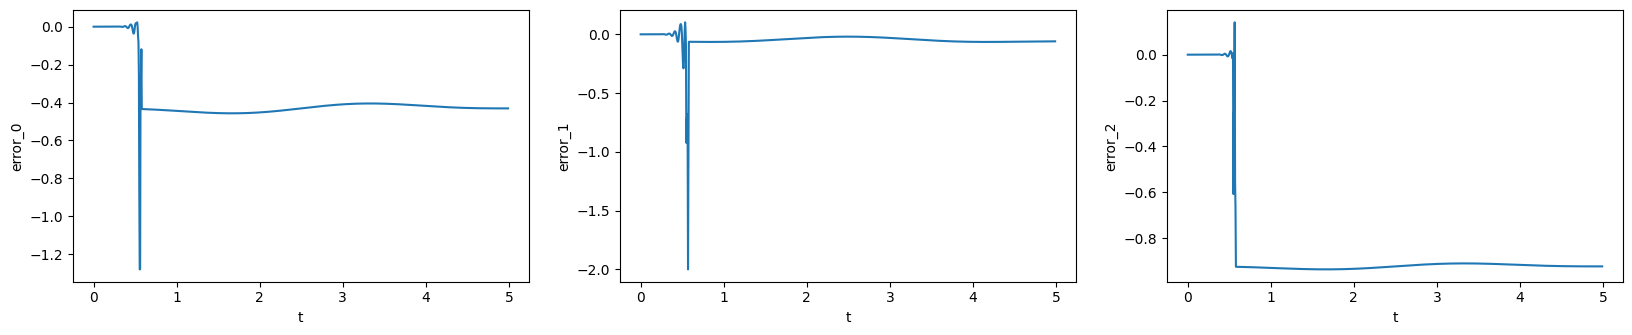

In [132]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

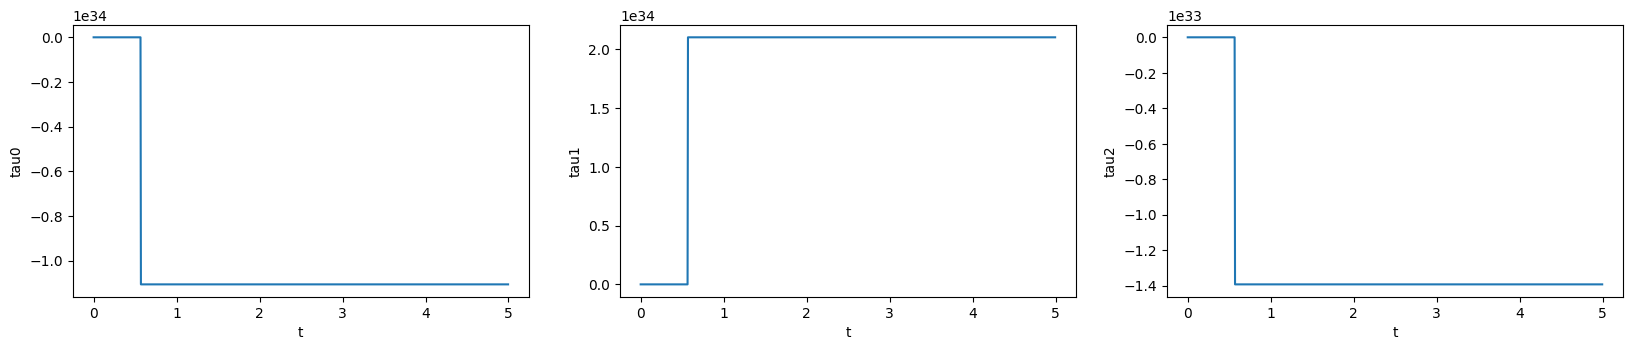

In [133]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

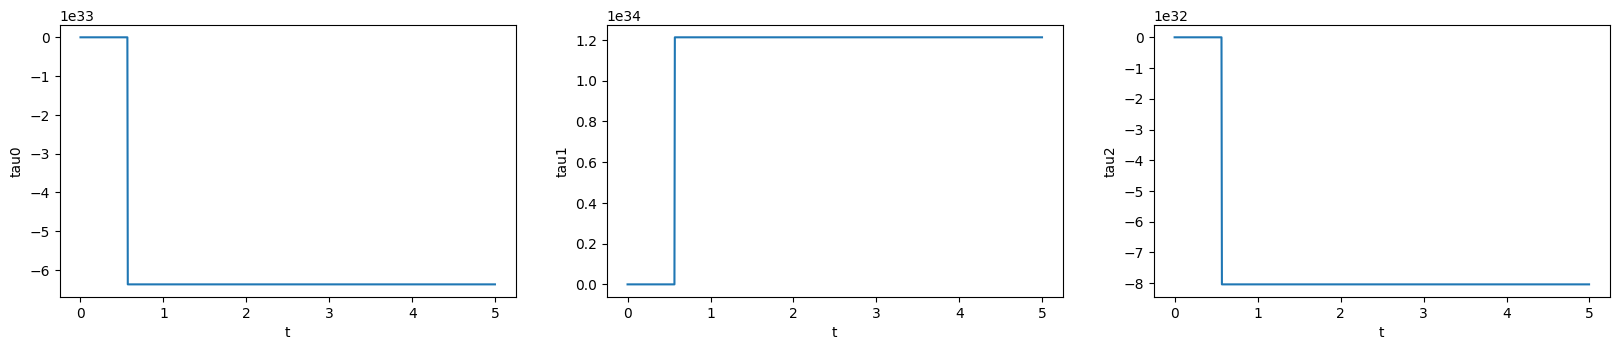

In [134]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

# ZNN Velcoity Level

In [135]:
gamma = 10
shape = 'cardioid'
c = 0.01
tilt = np.pi/6

In [136]:
## specify the matricies
z_ctrl = np.zeros((n_obs,num_snaps_ctrl))
z_dot = np.zeros((n_obs,num_snaps_ctrl-1))
x_ctrl = np.zeros((num_states,num_snaps_ctrl))
x_ctrl_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot_end = np.zeros((num_states_cart,num_snaps_ctrl))
x_ctrl_dot = np.zeros((num_states_cart,num_snaps_ctrl))
rd = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_dot = np.zeros((num_states_cart,num_snaps_ctrl-1))
rd_ddot = np.zeros((num_states_cart,num_snaps_ctrl-1))
error = np.zeros((num_states_cart,num_snaps_ctrl-1))

u_ctrl = np.zeros((num_inputs,num_snaps_ctrl))

## initialize the matricies
# x_ctrl[:,0] = np.hstack((x_ref[:,0],x_ref_dot[:,0]))
x_ctrl[:,0] = np.hstack((np.ones((num_joints,)), np.zeros((num_joints,))))
z_ctrl[:,0] = lift(x_ctrl[:,0],model_koop_dnn, net_params)
z_dot[:,0] = z_ctrl[:,i+1] = np.matmul(z_ctrl[:,0],Ac.T)+np.matmul(u_ctrl[:,0],Bc.T)
x_ctrl_end[:,0] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,0]).float()).detach().numpy()


In [137]:
for i in range(num_snaps_ctrl-1):
    t = t_ctrl[i]
    if modality == '2D':
        # rd[:,i], rd_dot[:,i],rd_ddot= path_pars_2D(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
    else:
        rd[:,i], rd_dot[:,i], rd_ddot[:,i] = path_pars(t,t_ctrl[-1],c,tilt,x_ctrl_end[:,0], shape)
        # rd[:,i], rd_dot[:,i] = x_end[:,i], x_end_dot[:,i]
        
    error[:,i] = x_ctrl_dot_end[:,i] - rd_dot[:,i]
    
    W = neural_jacobian(map_net, x_ctrl[:num_joints,i])
    W_dot = neural_jacobian_dot(map_net, x_ctrl[:num_joints,i],x_ctrl[num_joints:,i])
    J_tilde = np.hstack((W_dot,W))
    
    u_dot = np.dot(np.linalg.pinv(B), -np.matmul(A,z_dot[:,i]) + np.matmul(np.linalg.pinv(np.matmul(J_tilde, Cc)), (rd_ddot[:,i] - gamma*(error[:,i]))))
    
    # u_ctrl[:,i] = np.dot(np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,Bc))), -np.matmul(np.matmul(J_tilde, Cc),np.matmul(Ac,z_ctrl[:,i])) + rd_dot_full - gamma*(error[:,i]))
            
    if i < num_snaps_ctrl:
        u_ctrl[:,i+1] = u_ctrl[:,i] + u_dot*dt
    z_ctrl[:,i+1] = np.matmul(z_ctrl[:,i],A.T)+np.matmul(u_ctrl[:,i],B.T)
    x_ctrl[:,i+1] = np.matmul(z_ctrl[:,i+1],C.T)
    x_ctrl_end[:,i+1] = map_net.forward(torch.from_numpy(x_ctrl[:num_joints,i+1]).float()).detach().numpy()
    x_ctrl_dot_end[:,i+1] = np.matmul(neural_jacobian(map_net, x_ctrl[:num_joints,i+1]), x_ctrl[num_joints:,i+1])
    
                   
    # x_ctrl[0:3,i+1],x_ctrl[3:,i+1] = dynamics_3R(dt, u_ctrl[:,i], x_ctrl[0:3,i],x_ctrl[3:,i], robot_pars)
    # z_ctrl[:,i+1] = lift(x_ctrl[:,i+1],model_koop_dnn, net_params)
    

In [138]:
np.linalg.pinv(np.matmul(J_tilde,np.matmul(Cc,B))).mean()

-7143.7534

In [139]:
np.matmul(np.matmul(J_tilde, Cc),A).mean()

0.014454256

In [140]:
u_ctrl[:,10]

array([ 0.03168308, -0.84409892, -0.0497355 ])

In [141]:
np.matmul(J_tilde,Cc).shape

(3, 27)

In [142]:
np.vstack((rd_dot[:,i], rd_ddot[:,i]))

array([[ 1.49275052e-06, -1.58222670e-04,  7.46375262e-07],
       [-5.97090368e-04,  3.16416131e-02, -2.98545184e-04]])

In [143]:
np.linalg.pinv(np.matmul(W,np.matmul(Cr,Bc)))

array([[  251038.6  ,  -632459.6  ,  -515953.1  ],
       [  -88687.59 ,   -99469.516, -1431875.8  ],
       [ -436438.34 ,  -414731.5  ,    82540.305]], dtype=float32)

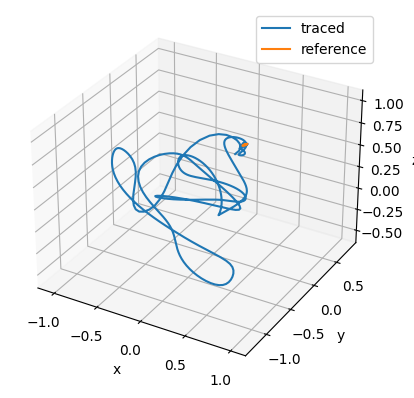

In [144]:
if modality == '2D':
    plt.figure(figsize=(20,12))
    plt.plot(x_ctrl_end[0,:],x_ctrl_end[1,:],label = 'traced')
    plt.plot(rd[0,:-1],rd[1,:-1],label ='reference')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.axis('equal')
else:
    ax = plt.axes(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    ax.plot3D(x_ctrl_end[0,:],x_ctrl_end[1,:],x_ctrl_end[2,:],label = 'traced')
    ax.plot3D(rd[0,:-1],rd[1,:-1],rd[2,:-1],label ='reference')
    plt.legend()

    plt.axis('equal')
    


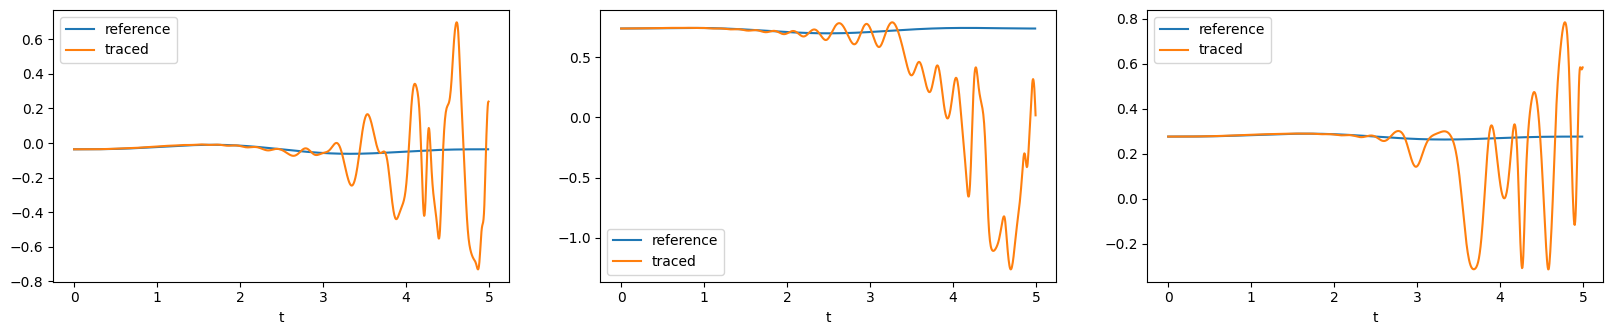

In [145]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],rd[i,:],label ='reference')
    plt.plot(t_ctrl[:],x_ctrl_end[i,:],label = 'traced')
    plt.xlabel('t')
    plt.legend()

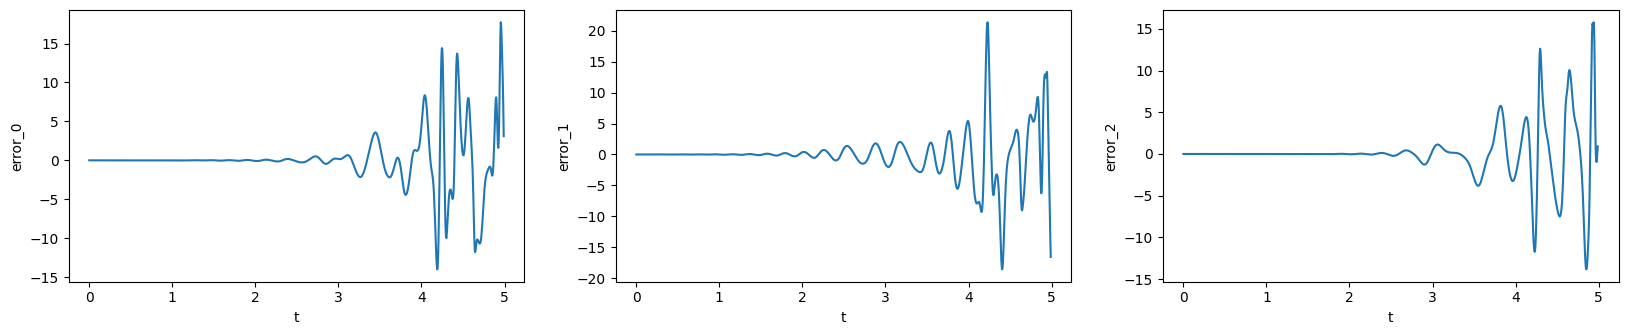

In [146]:
plt.figure(figsize=(20,12))
for i in range(int(num_states_cart)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:-1],error[i,:])
    plt.xlabel('t')
    plt.ylabel('error_' + str(i))
    

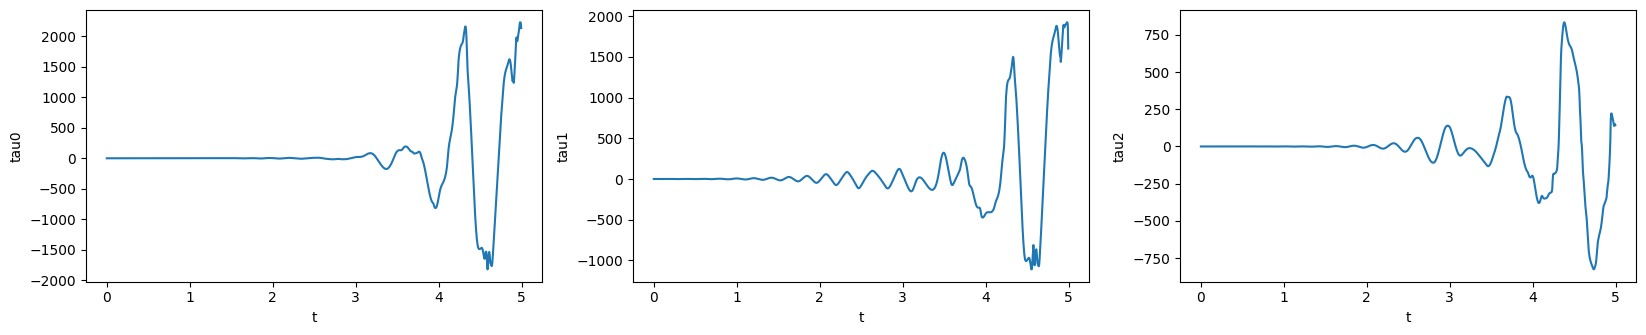

In [147]:
plt.figure(figsize=(20,12))
for i in range(int(num_joints)):
    plt.subplot(3,3,i+1)
    plt.plot(t_ctrl[:u_ctrl.shape[1]],u_ctrl[i,:])
    plt.xlabel('t')
    plt.ylabel('tau' + str(i))

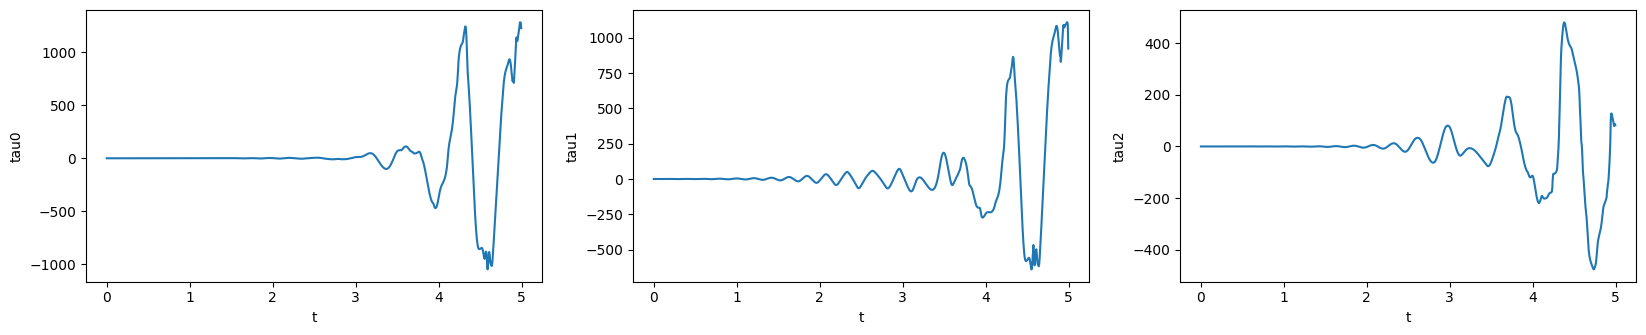

In [148]:
if standardize:
    u_znn_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in u_ctrl.T]).reshape(u_ctrl.shape[1],num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:u_ctrl.shape[1]],u_znn_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

## MPC

In [149]:
# Create Linear Model Instanse
bilinear_model = linear_Dynamics(sparse.csc_matrix(A),sparse.csc_matrix(B), C)

# Model parameters
solver_settings = {}
solver_settings['gen_embedded_ctrl'] = False
solver_settings['warm_start'] = True
solver_settings['polish'] = True
solver_settings['polish_refine_iter'] = 3
solver_settings['scaling'] = True
solver_settings['adaptive_rho'] = False
solver_settings['check_termination'] = 25
solver_settings['max_iter'] = 1000
solver_settings['eps_abs'] = 1e-6
solver_settings['eps_rel'] = 1e-6
solver_settings['eps_prim_inf'] = 1e-4
solver_settings['eps_dual_inf'] = 1e-4
solver_settings['linsys_solver'] = 'qdldl'

## set limits
umax = 20*np.array([1, 1, 1])
umin = -umax

xmax =  20*np.array([1, 1, 1, 1, 1, 1])
xmin = -xmax

In [150]:
traj_length = num_snaps_ctrl
max_iter = 100
N = 5 #length of horizon
t_eval = dt * np.arange(traj_length+1)          # Simulation time points, closed loop
Q_mpc =  1e5*sparse.eye(num_states)       # State penalty matrix, trajectory generation
QN_mpc = 1*sparse.eye(num_states)       # Final state penalty matrix, trajectory generation
R_mpc =  1*sparse.eye(num_inputs)         # Actuation penalty matrix, trajectory generation
R0_mpc = sparse.csc_matrix(np.zeros(num_inputs))

# Design trajectory:
x0 = x_ref_full[:,0]                        
# State constraints, trajectory generation
# Define initial solution for SQP algorithm:
x_init = np.linspace(x0, x0, N+1)
u_init = 1*np.ones((num_inputs, N)).T

In [151]:
z_init = np.empty((N+1, n_obs))
z0 = lift(x0, model_koop_dnn, net_params)
for i in range(N+1):
    z_init[i,:] = lift(x_init[i,:], model_koop_dnn, net_params)

In [152]:
controller_nmpc = NonlinearMPCController(bilinear_model, N, dt, umin, umax, xmin, xmax, Q_mpc, R_mpc, QN_mpc, solver_settings)
controller_nmpc.construct_controller(z_init, u_init,x_ref_full[:,0])

In [153]:
controller_nmpc.trajectory_tracking(x0, z0, x_ref_full.T, max_iter)

time_step 0
time_step 1
time_step 2
time_step 3
time_step 4
time_step 5
time_step 6
time_step 7
time_step 8
time_step 9
time_step 10
time_step 11
time_step 12
time_step 13
time_step 14
time_step 15
time_step 16
time_step 17
time_step 18
time_step 19
time_step 20
time_step 21
time_step 22
time_step 23
time_step 24
time_step 25
time_step 26
time_step 27
time_step 28
time_step 29
time_step 30
time_step 31
time_step 32
time_step 33
time_step 34
time_step 35
time_step 36
time_step 37
time_step 38
time_step 39
time_step 40
time_step 41
time_step 42
time_step 43
time_step 44
time_step 45
time_step 46
time_step 47
time_step 48
time_step 49
time_step 50
time_step 51
time_step 52
time_step 53
time_step 54
time_step 55
time_step 56
time_step 57
time_step 58
time_step 59
time_step 60
time_step 61
time_step 62
time_step 63
time_step 64
time_step 65
time_step 66
time_step 67
time_step 68
time_step 69
time_step 70
time_step 71
time_step 72
time_step 73
time_step 74
time_step 75
time_step 76
time_step

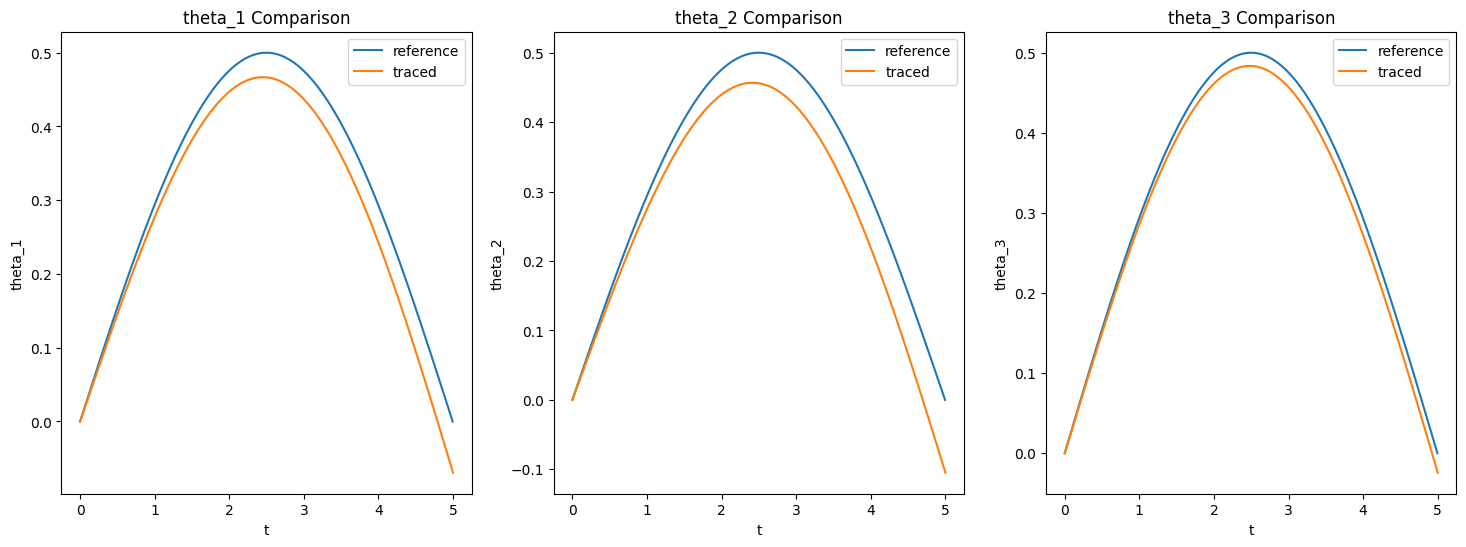

In [154]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_ctrl[:],x_ref[0,:],label ='reference')
plt.plot(t_eval,controller_nmpc.x_traced[:,0],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_ctrl[:],x_ref[1,:],label ='reference')
plt.plot(t_eval,controller_nmpc.x_traced[:,1],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2 Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_ctrl[:],x_ref[2,:],label ='reference')
plt.plot(t_eval,controller_nmpc.x_traced[:,2],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.title('theta_3 Comparison')
plt.legend()

Text(0.5, 1.0, 'error_3 Comparison')

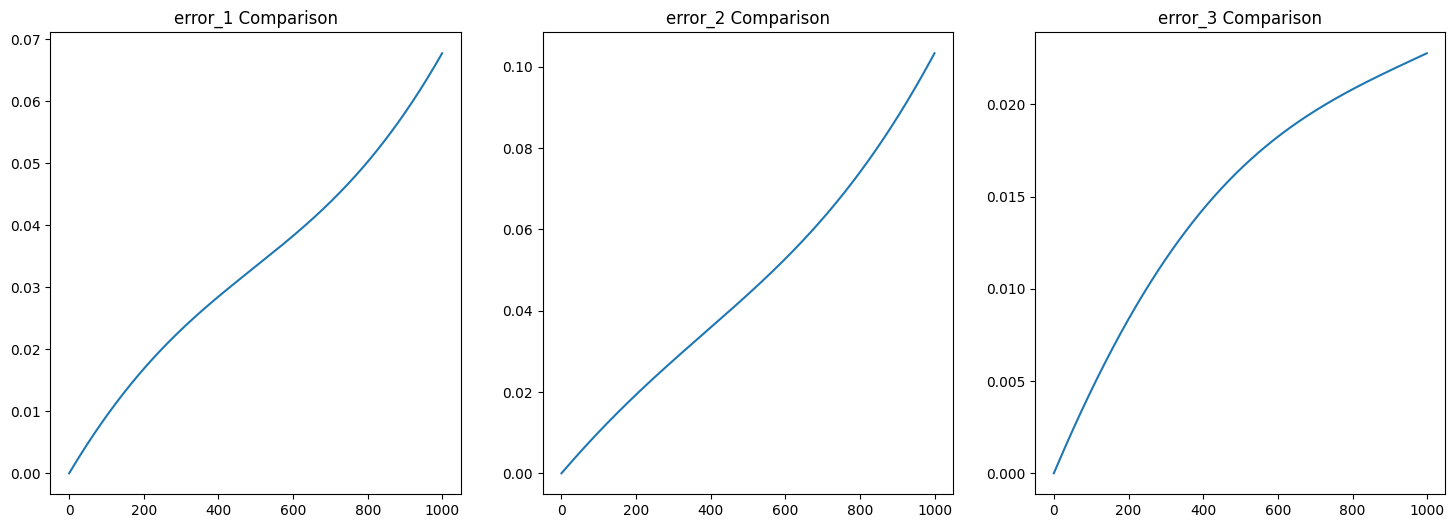

In [155]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(x_ref[0,:] - controller_nmpc.x_traced[:x_ref.shape[1],0])
plt.title('error_1 Comparison')

plt.subplot(1,3,2)
plt.plot(x_ref[1,:] - controller_nmpc.x_traced[:x_ref.shape[1],1])
plt.title('error_2 Comparison')

plt.subplot(1,3,3)
plt.plot(x_ref[2,:] - controller_nmpc.x_traced[:x_ref.shape[1],2])
plt.title('error_3 Comparison')

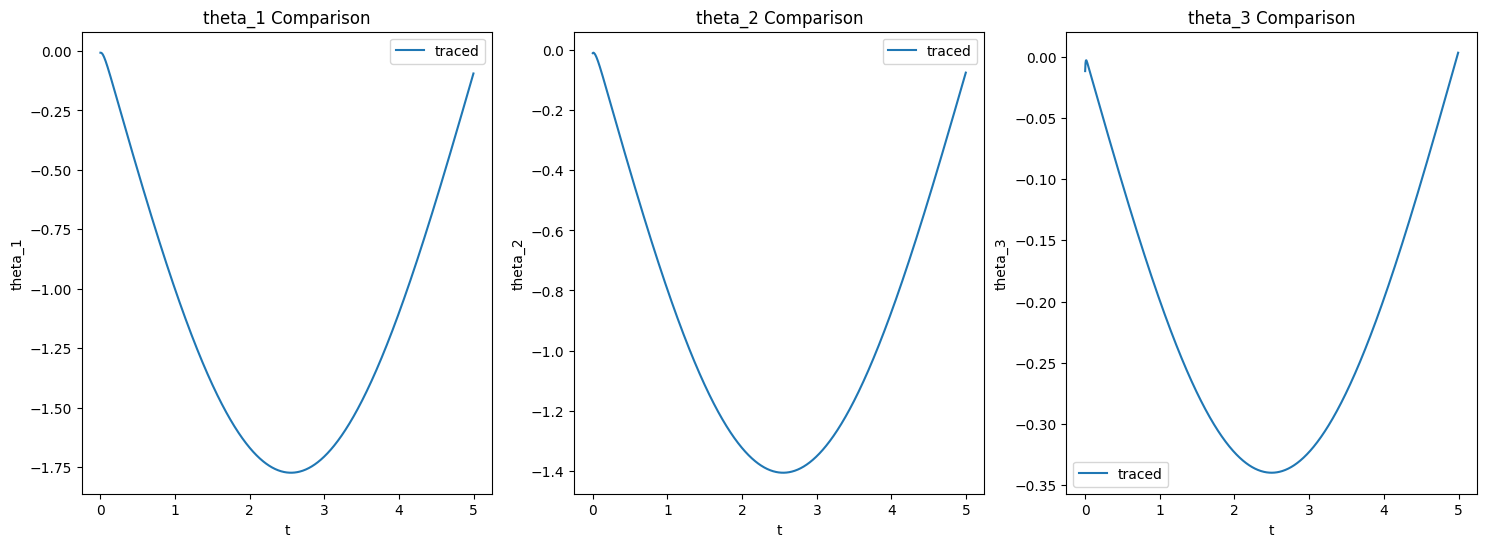

In [156]:
plt.figure(figsize=(18, 6)) 
plt.subplot(1,3,1)
plt.plot(t_eval[:-1],controller_nmpc.controls[:,0],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_1')
plt.title('theta_1 Comparison')
plt.legend()

plt.subplot(1,3,2)
plt.plot(t_eval[:-1],controller_nmpc.controls[:,1],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_2')
plt.title('theta_2 Comparison')
plt.legend()

plt.subplot(1,3,3)
plt.plot(t_eval[:-1],controller_nmpc.controls[:,2],label = 'traced')
plt.xlabel('t')
plt.ylabel('theta_3')
plt.title('theta_3 Comparison')
plt.legend()

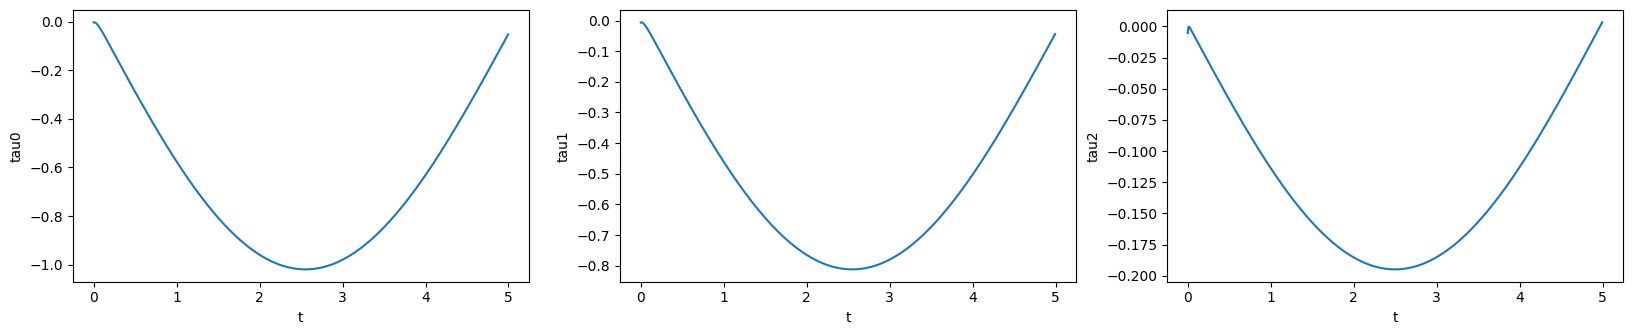

In [157]:
if standardize:
    u_mpc_unscaled = np.array([standardizer_u_kdnn.inverse_transform(d.reshape(1,-1)) for d in controller_nmpc.controls]).reshape(num_snaps_val,num_inputs)
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:-1],u_mpc_unscaled[:,i], label= 'unscaled')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))

In [158]:
standardizer_u_kdnn.scale_


array([0.57620493, 0.57699951, 0.57736866])

In [159]:
standardizer_u_kdnn.mean_[1]


-0.000657699875452319

In [160]:
standardizer_u_kdnn.var_

array([0.33201212, 0.33292843, 0.33335457])

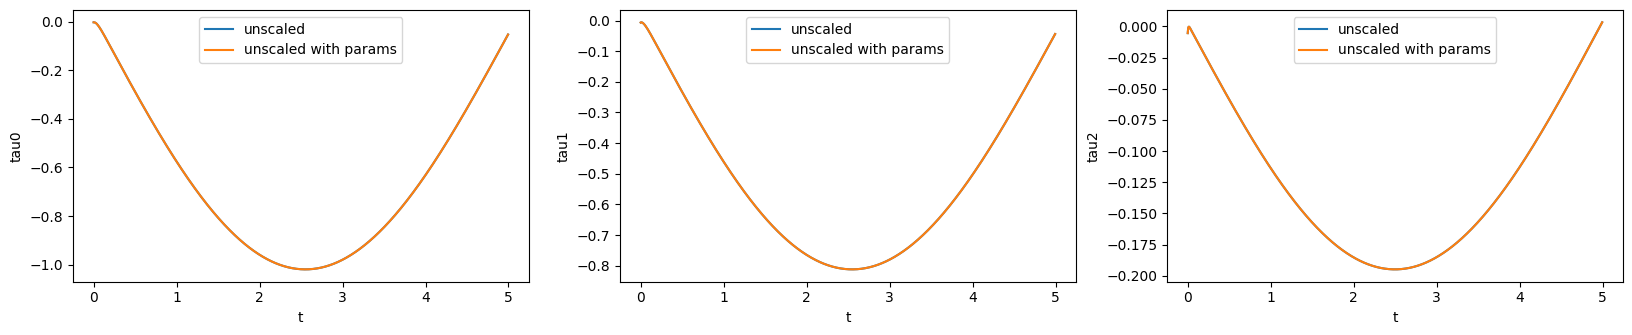

In [161]:
if standardize:
    plt.figure(figsize=(20,12))
    for i in range(int(num_joints)):
        plt.subplot(3,3,i+1)
        plt.plot(T[:-1],u_mpc_unscaled[:,i], label= 'unscaled')
        plt.plot(T[:-1], controller_nmpc.controls[:,i]*standardizer_u_kdnn.scale_[i] + standardizer_u_kdnn.mean_[i], label= 'unscaled with params')
        plt.xlabel('t')
        plt.ylabel('tau' + str(i))
        plt.legend()

In [162]:
map_net.map_net_in.weight.shape

torch.Size([20, 3])